# References

1. https://colab.research.google.com/github/styler00dollar/Colab-Detectron2/blob/resnest/Colab-Detectron2.ipynb#scrollTo=ZyAvNCJMmvFF
2. https://colab.research.google.com/github/styler00dollar/Colab-Detectron2/blob/resnest/Colab-Detectron2.ipynb#scrollTo=PIbAM2pv-urF
3. https://www.kaggle.com/code/banddaniel/bone-fracture-detect-resnet-50-resnext-101-fpns/notebook

# 1. Downloading Dataset and Dependencies

Dependencies

In [ ]:
!pip install cython pyyaml==5.1

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


Detectron 2

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-0de1oz3c
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-0de1oz3c
  Resolved https://github.com/facebookresearch/detectron2.git to commit eb96ee1d4752ff5896f623f738641fba9c755237
  Preparing metadata (setup.py) ... done


Dataset (COCO Annotations)

In [ ]:
!curl -s -L "https://universe.roboflow.com/ds/7C3auvDRDG?key=bfR1xnDmVh" > roboflow.zip; unzip -o -qq roboflow.zip; rm roboflow.zip

# 2. Dataset

## 2.1 Registering Dataset

Regestering a dataset for each split

In [ ]:
from detectron2.data.datasets import register_coco_instances

splits = {
    'train': '/content/train',
    'test': '/content/test',
    'valid': '/content/valid'
}

for key in splits.keys():
    register_coco_instances(f"fractect_{key}", {}, f"/content/{key}/_annotations.coco.json", f"/content/{key}")

AssertionError: Dataset 'fractect_train' is already registered!

## 2.2 Visualising Training Data

Ensuring datasets are loaded

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog

for key in splits.keys():
    dataset_dicts = DatasetCatalog.get(f"fractect_{key}")
    metadata = MetadataCatalog.get(f"fractect_{key}")

    print(f"Dataset {key}:")
    print(f"- Number of images: {len(dataset_dicts)}")
    print(f"- Metadata classes: {metadata.get('thing_classes')}")

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Dataset train:
- Number of images: 3631
- Metadata classes: ['bones', 'elbow positive', 'fingers positive', 'forearm fracture', 'humerus', 'humerus fracture', 'shoulder fracture', 'wrist positive']


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Dataset test:
- Number of images: 169
- Metadata classes: ['bones', 'elbow positive', 'fingers positive', 'forearm fracture', 'humerus', 'humerus fracture', 'shoulder fracture', 'wrist positive']
Dataset valid:
- Number of images: 348
- Metadata classes: ['bones', 'elbow positive', 'fingers positive', 'forearm fracture', 'humerus', 'humerus fracture', 'shoulder fracture', 'wrist positive']


Visualising training examples

In [ ]:
from detectron2.utils.visualizer import Visualizer
import random
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

my_dataset_train_metadata = MetadataCatalog.get("fractect_train")
train_dataset_dicts = DatasetCatalog.get("fractect_train")

from detectron2.utils.visualizer import Visualizer
import random
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

def visualize_training_data(dataset_dict, dataset_metadata, num_images=6):
  """
  Visualizes and displays the specified number of random images with bounding boxes
  from the training dataset. Skips images without any bounding boxes in annotations.

  Args:
      dataset_dict (list): A list of dataset dictionaries containing image and annotation information.
      dataset_metadata (Metadata): The metadata for the dataset.
      num_images (int, optional): The number of images to display. Defaults to 6.
  """

  random.seed()
  images_with_boxes = []

  for im in dataset_dict:
    if any(ann["bbox"] for ann in im["annotations"]):
      images_with_boxes.append(im)

  images = random.sample(images_with_boxes, num_images)

  rows = int(np.ceil(np.sqrt(num_images)))
  cols = max(num_images // rows, 1)

  fig, axs = plt.subplots(rows, cols, figsize=(18, 12), dpi=100)

  for i in range(num_images):
    row = i // cols
    col = i % cols
    im = images[i]
    img_link = im['file_name']
    img_id = im['image_id']

    img = cv2.imread(img_link)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    visualizer = Visualizer(img, metadata=dataset_metadata)
    vis = visualizer.draw_dataset_dict(im)
    final_img = vis.get_image()

    axs[row, col].axis('off')
    axs[row, col].imshow(final_img)

  plt.tight_layout()
  plt.show()


visualize_training_data(train_dataset_dicts, my_dataset_train_metadata, num_images=8)  # Example with 4 images

# 3. Defining Model

## 3.1 Config

Setting up Detectron trainer config

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.config import CfgNode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import os

EPOCHS = 20000
CLASSES = 8
LR = 0.001
MODEL = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

def load_config(model_yaml: str, workers: int, dataset: str, lr: float, epochs: int, classes: int) -> CfgNode:
  """
  Loads and configures a Detectron2 model from a YAML file.

  Args:
      model_yaml (str): Path to the YAML configuration file for the model.
      workers (int): The number of data loading worker processes.
      dataset (str): The name of the dataset used for training.
      lr (float): The base learning rate for the optimizer.
      epochs (int): The number of training epochs.
      classes (int): The number of object classes in the dataset.

  Returns:
      CfgNode: A Detectron2 configuration object representing the loaded and modified model configuration.
  """

  cfg = get_cfg()
  cfg.merge_from_file(model_zoo.get_config_file(model_yaml))

  # Dataset configuration
  cfg.DATASETS.TRAIN = dataset
  cfg.DATASETS.TEST = ("fractect_valid",)
  cfg.TEST.EVAL_PERIOD = 500

  # Data loading settings
  cfg.DATALOADER.NUM_WORKERS = workers

  # Model weights and training parameters
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_yaml)
  cfg.SOLVER.MAX_ITER = epochs
  cfg.SOLVER.IMS_PER_BATCH = 2
  cfg.SOLVER.BASE_LR = lr
  cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
  cfg.MODEL.ROI_HEADS.NUM_CLASSES = classes
  cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

  os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

  return cfg

cfg = load_config(MODEL, 2, "fractect_train", LR, EPOCHS, CLASSES)

# 4. Training Model

## 4.1 Training

Custom trainer with validation callbacks to obtain mAP scores

In [ ]:
from detectron2.data import build_detection_train_loader
import detectron2.data.transforms as T
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class TrainerWithValidation(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        """
        Create an evaluator for the given dataset.
        """
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

class TrainerWithCustomDataLoader(TrainerWithValidation):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg)


trainer = TrainerWithCustomDataLoader(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[03/26 05:43:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

## 4.2 Saving Weights

Saving our model weights

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3

# 5. Results

## 5.1 Retrieving Metrics

Final evaluation using validation dataset

In [ ]:
evaluator = COCOEvaluator("fractect_valid", False, output_dir="/content/output/")
test_loader = build_detection_test_loader(cfg, "fractect_valid")
inference_on_dataset(trainer.model, test_loader, evaluator)
inference_on_dataset(trainer.model, test_loader, evaluator)

WARNING [03/26 02:40:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/26 02:40:56 d2.data.datasets.coco]: Loaded 348 images in COCO format from /content/valid/_annotations.coco.json
[03/26 02:40:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/26 02:40:56 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/26 02:40:56 d2.data.common]: Serializing 348 elements to byte tensors and concatenating them all ...
[03/26 02:40:56 d2.data.common]: Serialized dataset takes 0.09 MiB
[03/26 02:40:56 d2.evaluation.evaluator]: Start inference on 348 batches
[03/26 02:41:01 d2.evaluation.evaluator]: Inference done 24/348. Dataloading: 0.0018 s/iter. Inference: 0.1723 s/iter. Eval: 0.0003 s/iter. Total: 0.1744 s/iter. ETA=0:00:56
[03/26 02:41:06 d2.evaluation.

OrderedDict([('bbox',
              {'AP': 5.436306469466703,
               'AP50': 16.56489627110235,
               'AP75': 1.095494055109918,
               'APs': 0.18833839029064192,
               'APm': 4.75969804806492,
               'APl': 8.554481272105114,
               'AP-bones': nan,
               'AP-elbow positive': 0.6826807873901376,
               'AP-fingers positive': 3.2529165438970895,
               'AP-forearm fracture': 14.249493182324741,
               'AP-humerus': nan,
               'AP-humerus fracture': 10.322351133699398,
               'AP-shoulder fracture': 2.394109466268445,
               'AP-wrist positive': 1.7162877032204067})])

In [ ]:
# Reference 3
import json

def reading_metrics_from_json(metrics_path):
    metrics = []

    with open(metrics_path, 'r') as f:
        for line in f:
            metrics.append(json.loads(line))
    return metrics


def metric(metrics, specific_metric):
    metric = []
    for i in range(len(metrics)):
        try:
            metric.append(metrics[i][specific_metric])
        except KeyError:
            pass

    return metric

In [ ]:
train_metrics = reading_metrics_from_json('/content/output/metrics.json')

total_loss = metric(train_metrics, 'total_loss')
class_accuracy = metric(train_metrics, 'fast_rcnn/fg_cls_accuracy')
loss_box_reg = metric(train_metrics, 'loss_box_reg')

AP = metric(train_metrics, 'bbox/AP')
APm = metric(train_metrics, 'bbox/APm')
APl = metric(train_metrics, 'bbox/APl')
APs = metric(train_metrics, 'bbox/APs')

iterations = np.arange(1,EPOCHS,EPOCHS/len(total_loss))

In [ ]:
metrics_df = pd.DataFrame({
    'Iteration': iterations,
    'Total Loss': total_loss,
    'Class Accuracy': class_accuracy,
    'Box Reg Loss': loss_box_reg
})

## 5.2 Plotting Metrics

Accuracy / Loss

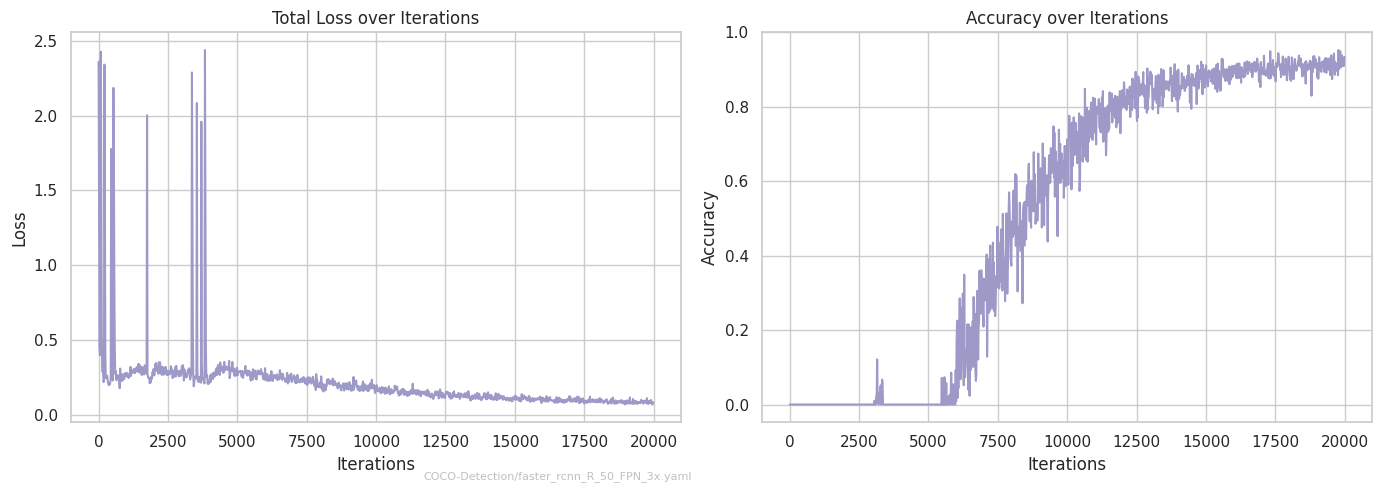

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Seaborn Format
sns.set_theme(style='whitegrid')
dark_palette = sns.color_palette('Purples', n_colors=1)
sns.set_palette(dark_palette)

# Figure
fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # Adjusted width

# Plot Loss
sns.lineplot(linewidth=2.5, ax=axs[0])
axs[0].plot(iterations, total_loss)
axs[0].set_title('Total Loss over Iterations')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Loss')

# Plot Accuracy
sns.lineplot(linewidth=2.5, ax=axs[1])
axs[1].set_title('Accuracy over Iterations')
axs[1].plot(iterations, class_accuracy)
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Accuracy')


# Model Text
plt.gcf().text(0.5, 0.02, MODEL, fontsize=8, color='gray', ha='right', va='bottom', alpha=0.5)

plt.tight_layout()
plt.show()

AP, APm, APl

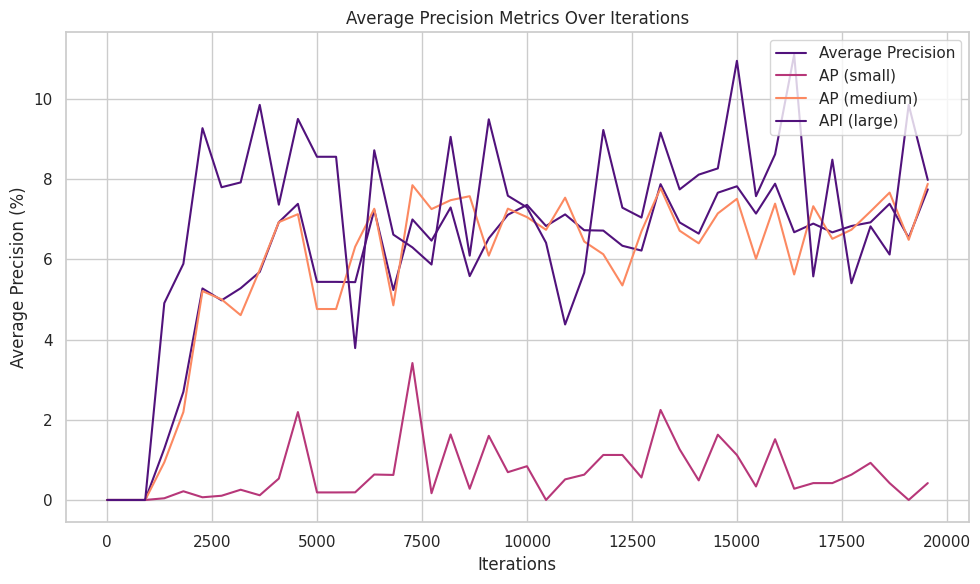

In [ ]:
# Reference 3

iterations = np.arange(1,EPOCHS,EPOCHS/len(AP))

sns.set_theme(style='whitegrid')
dark_palette = sns.color_palette('magma', n_colors=3)
sns.set_palette(dark_palette)

plt.figure(figsize=(10, 6))
plt.plot(iterations, AP, label='Average Precision', linewidth=1.5)
plt.plot(iterations, APs, label='AP (small)', linewidth=1.5)
plt.plot(iterations, APm, label='AP (medium)', linewidth=1.5)
plt.plot(iterations, APl, label='APl (large)', linewidth=1.5)

plt.title('Average Precision Metrics Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Average Precision (%)')
plt.legend()
plt.tight_layout()
plt.savefig("APMetrics.png")
plt.show()

# 6. Inference

For test dataset images

In [ ]:
# Reference 3

def create_predictions(dataset_dict, dataset_metadata, seed, image_scale = 1):
    np.random.seed(seed=seed)
    images = np.random.permutation(dataset_dict)[:3]

    fig, axs = plt.subplots(3,2, figsize = (10,15), dpi = 200)

    for i in range(3):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer1 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)

        vis_original = visualizer1.draw_dataset_dict(im)
        original_bbox = vis_original.get_image()

        visualizer2 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        outputs = predictor(img)
        out = visualizer2.draw_instance_predictions(outputs["instances"].to("cpu"))
        out_img = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
        final_bbox = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)

        axs[i][0].set_title('original bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][0].axis('off')
        axs[i][0].imshow(original_bbox)

        axs[i][1].set_title('predicted bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][1].axis('off')
        axs[i][1].imshow(final_bbox)

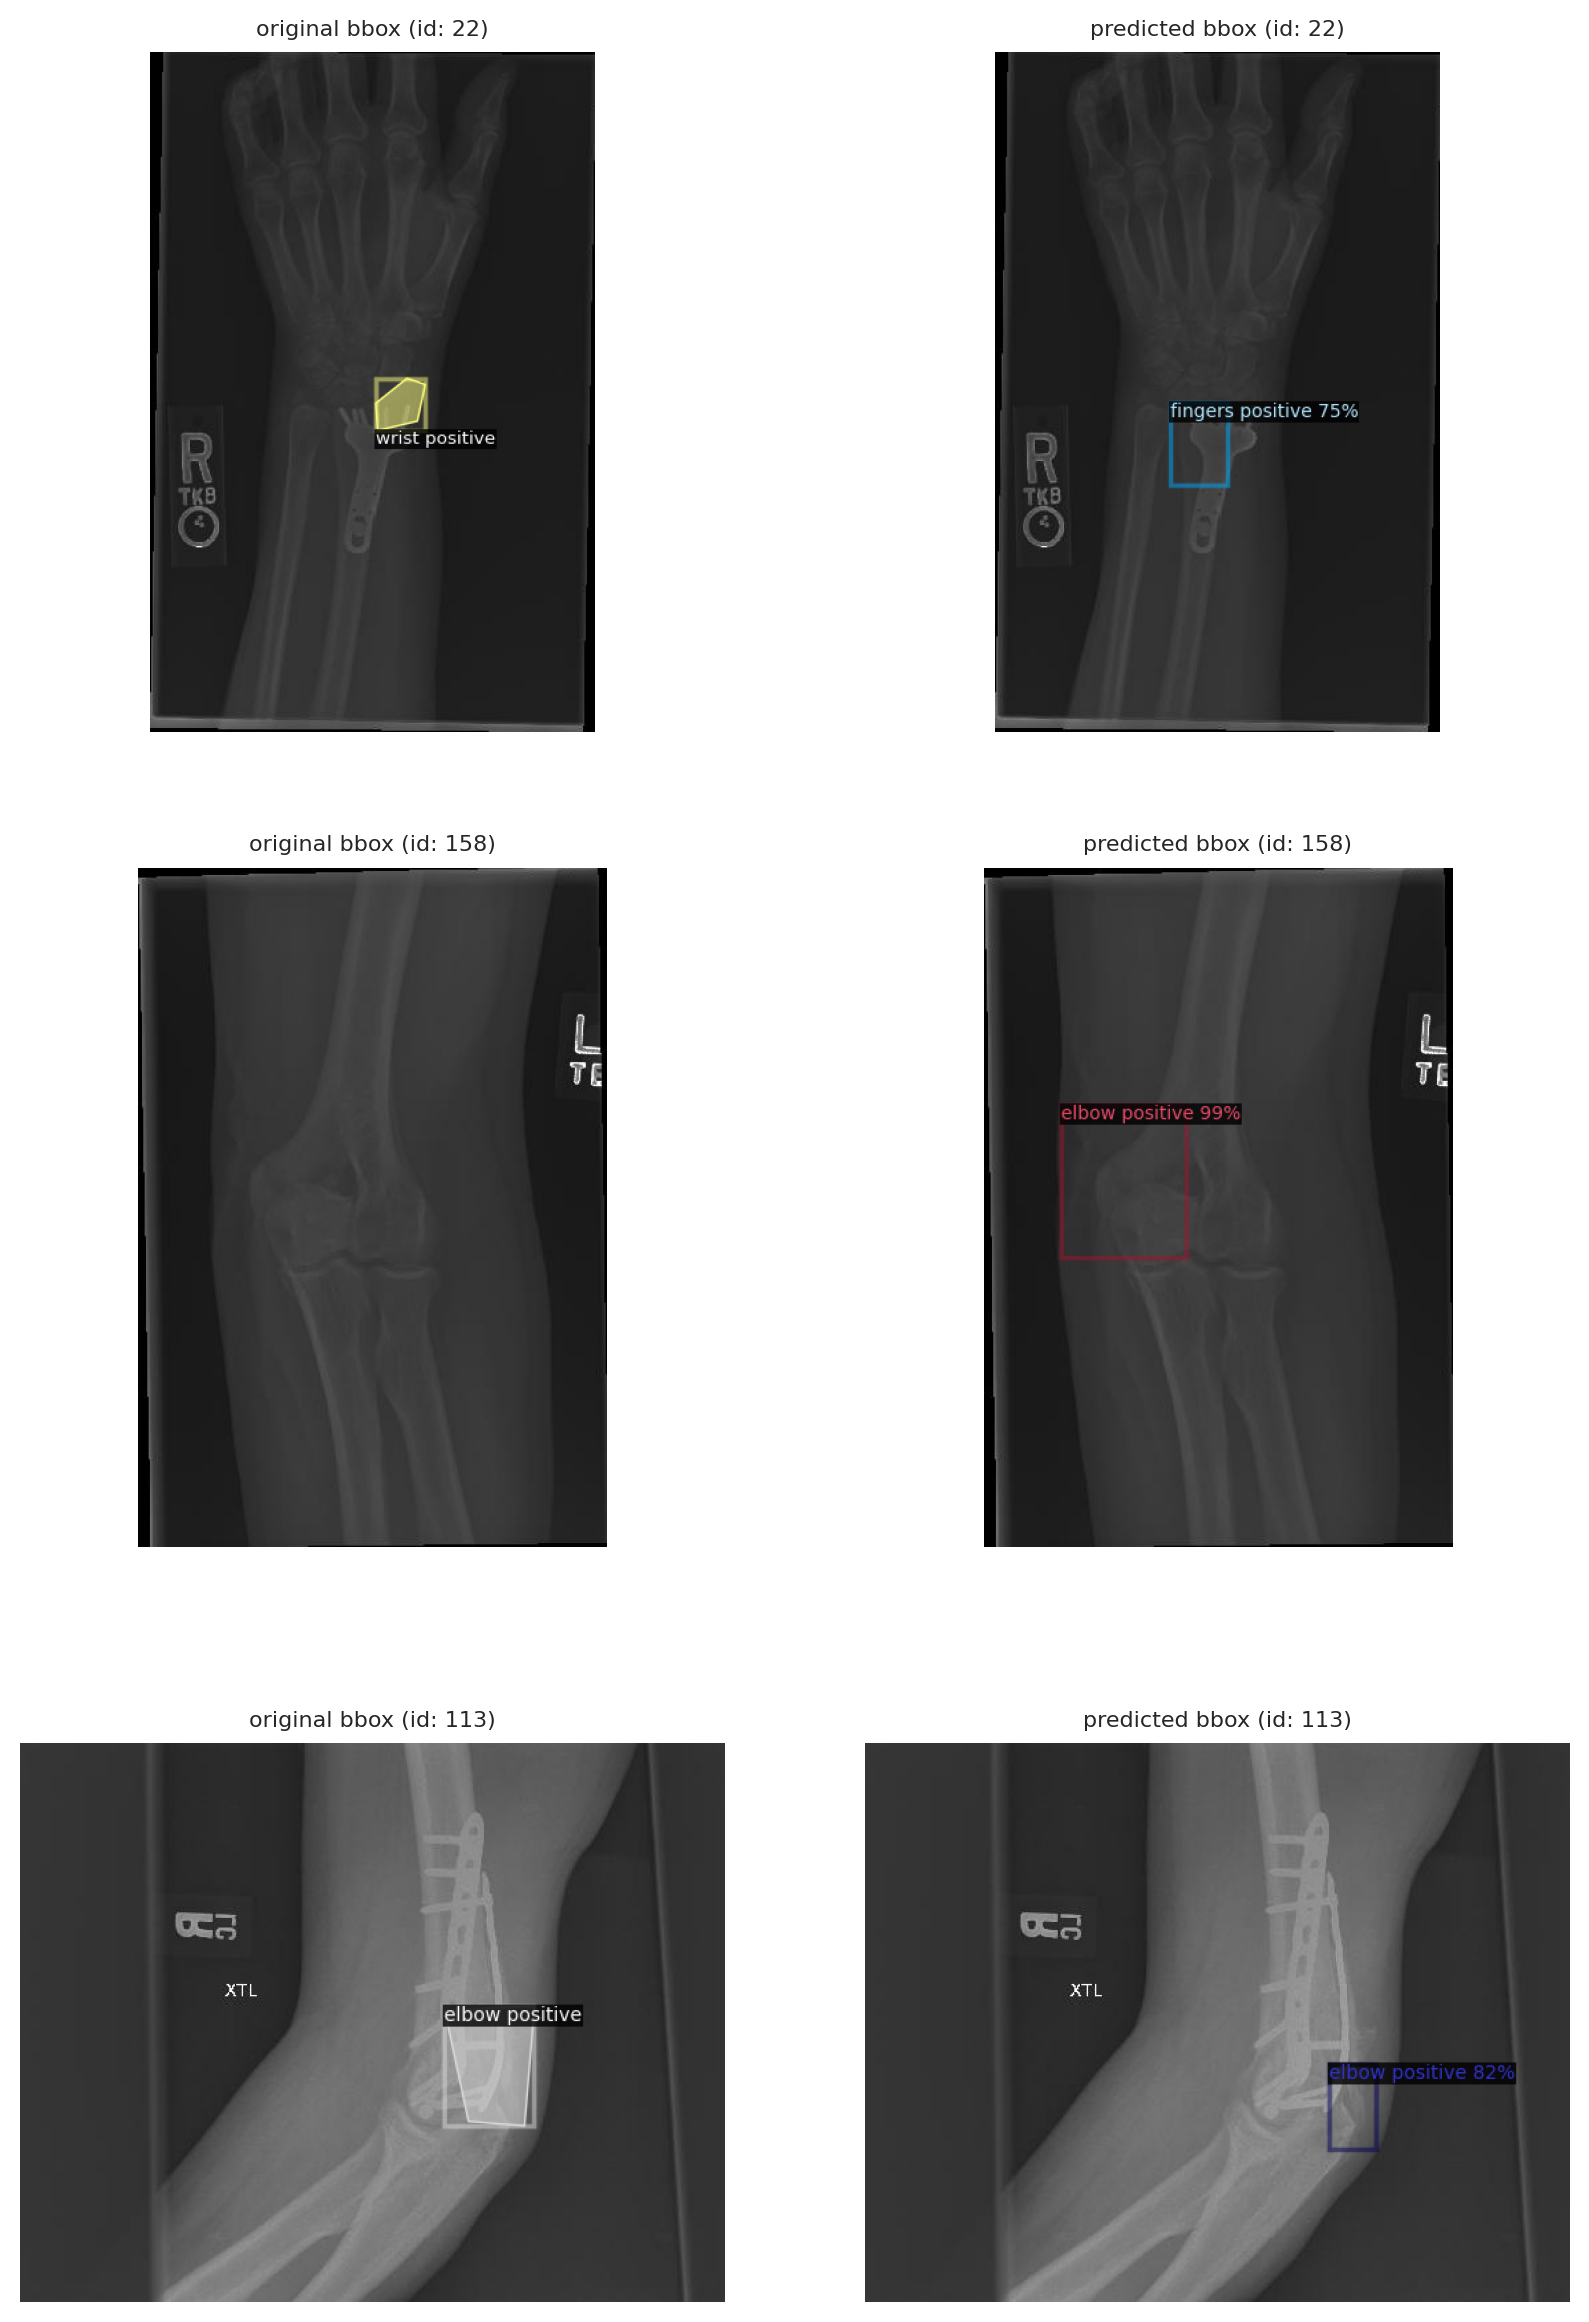

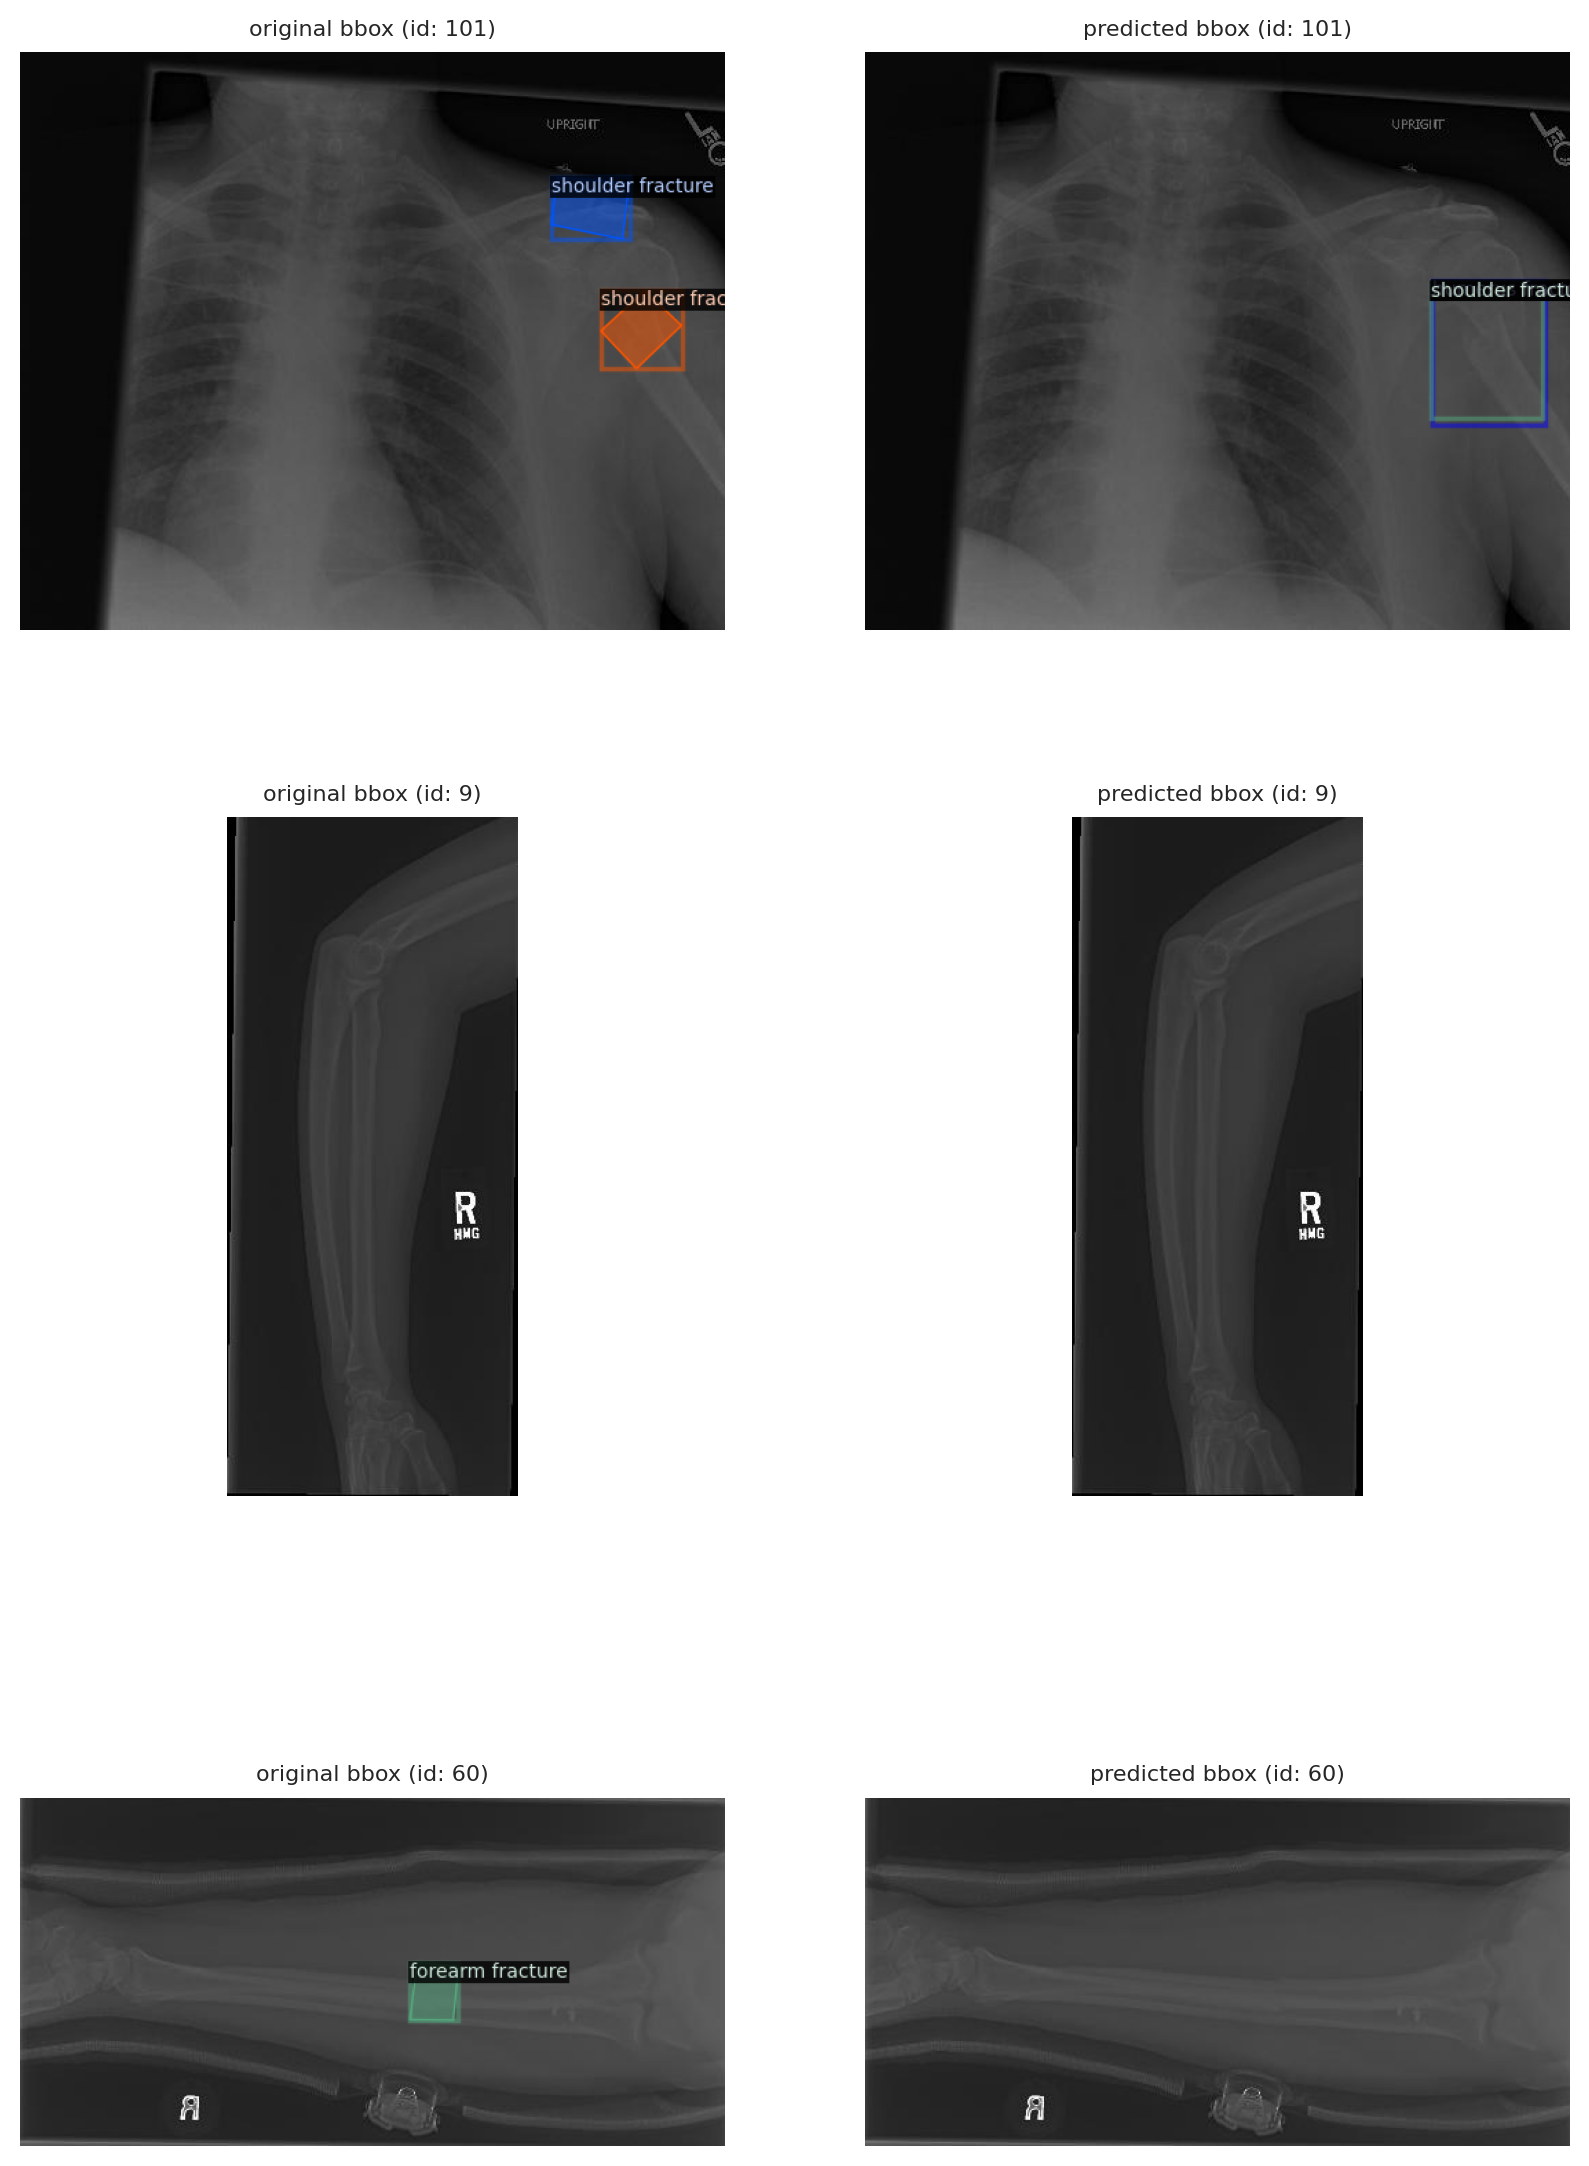

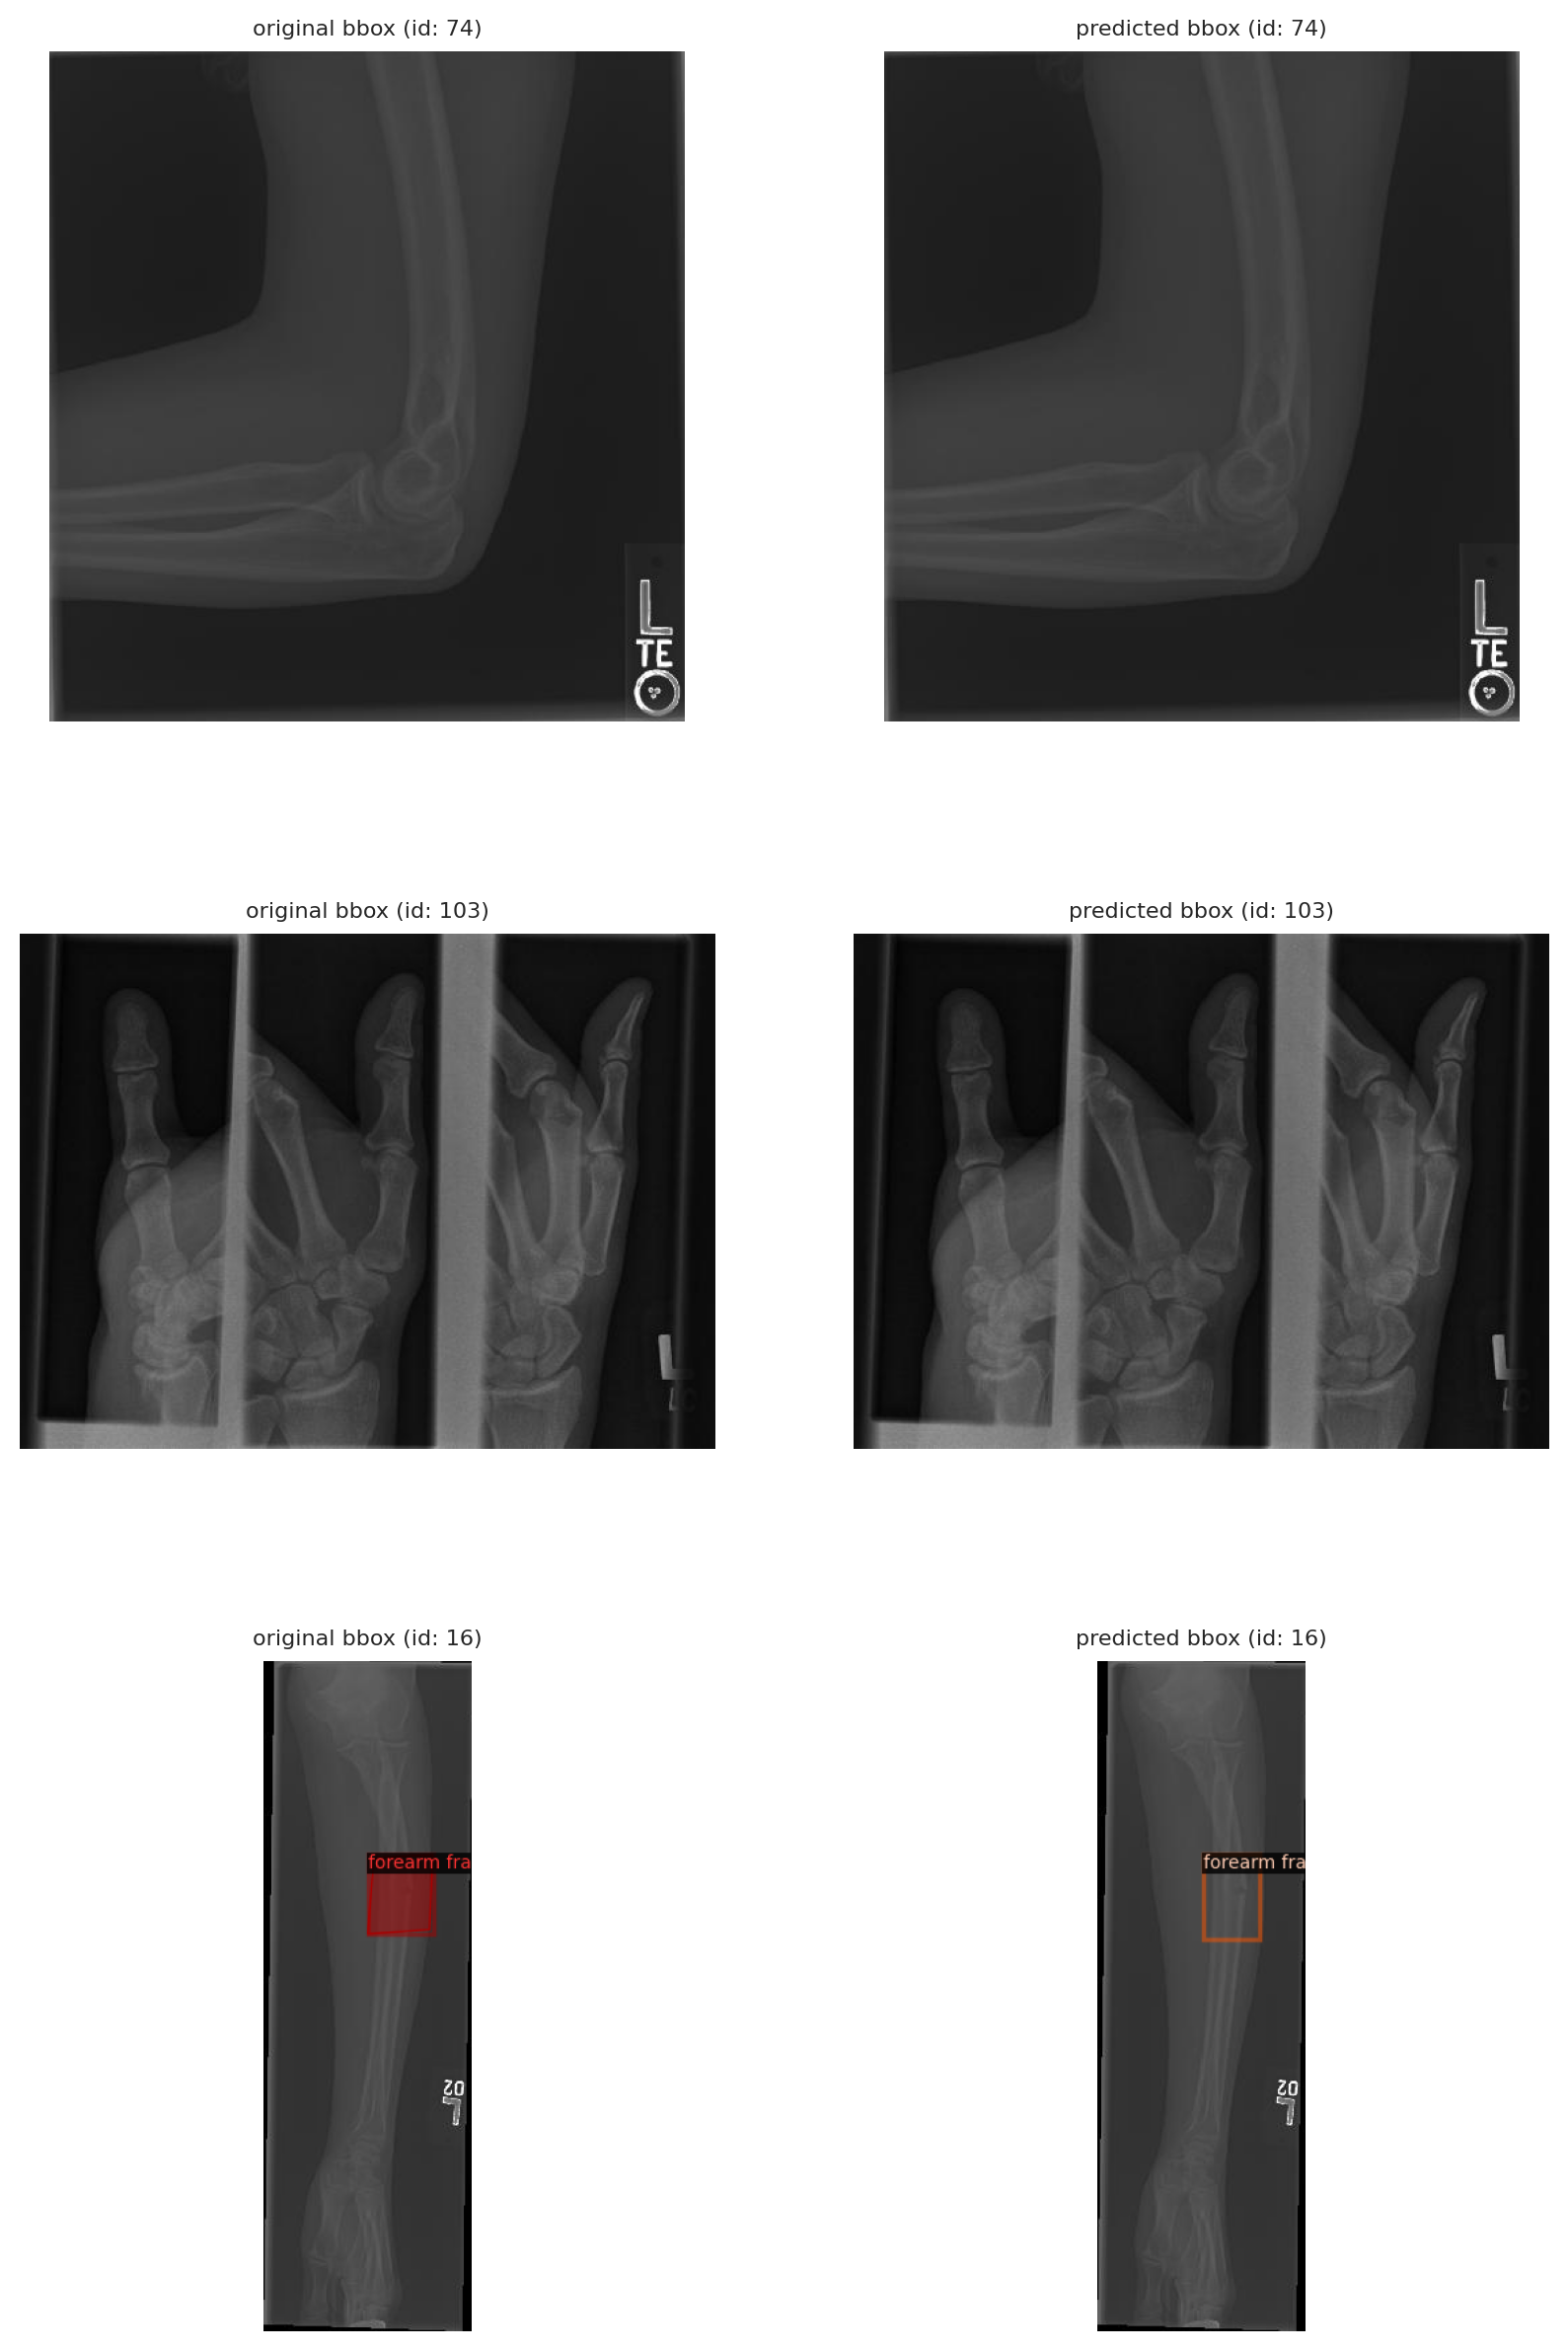

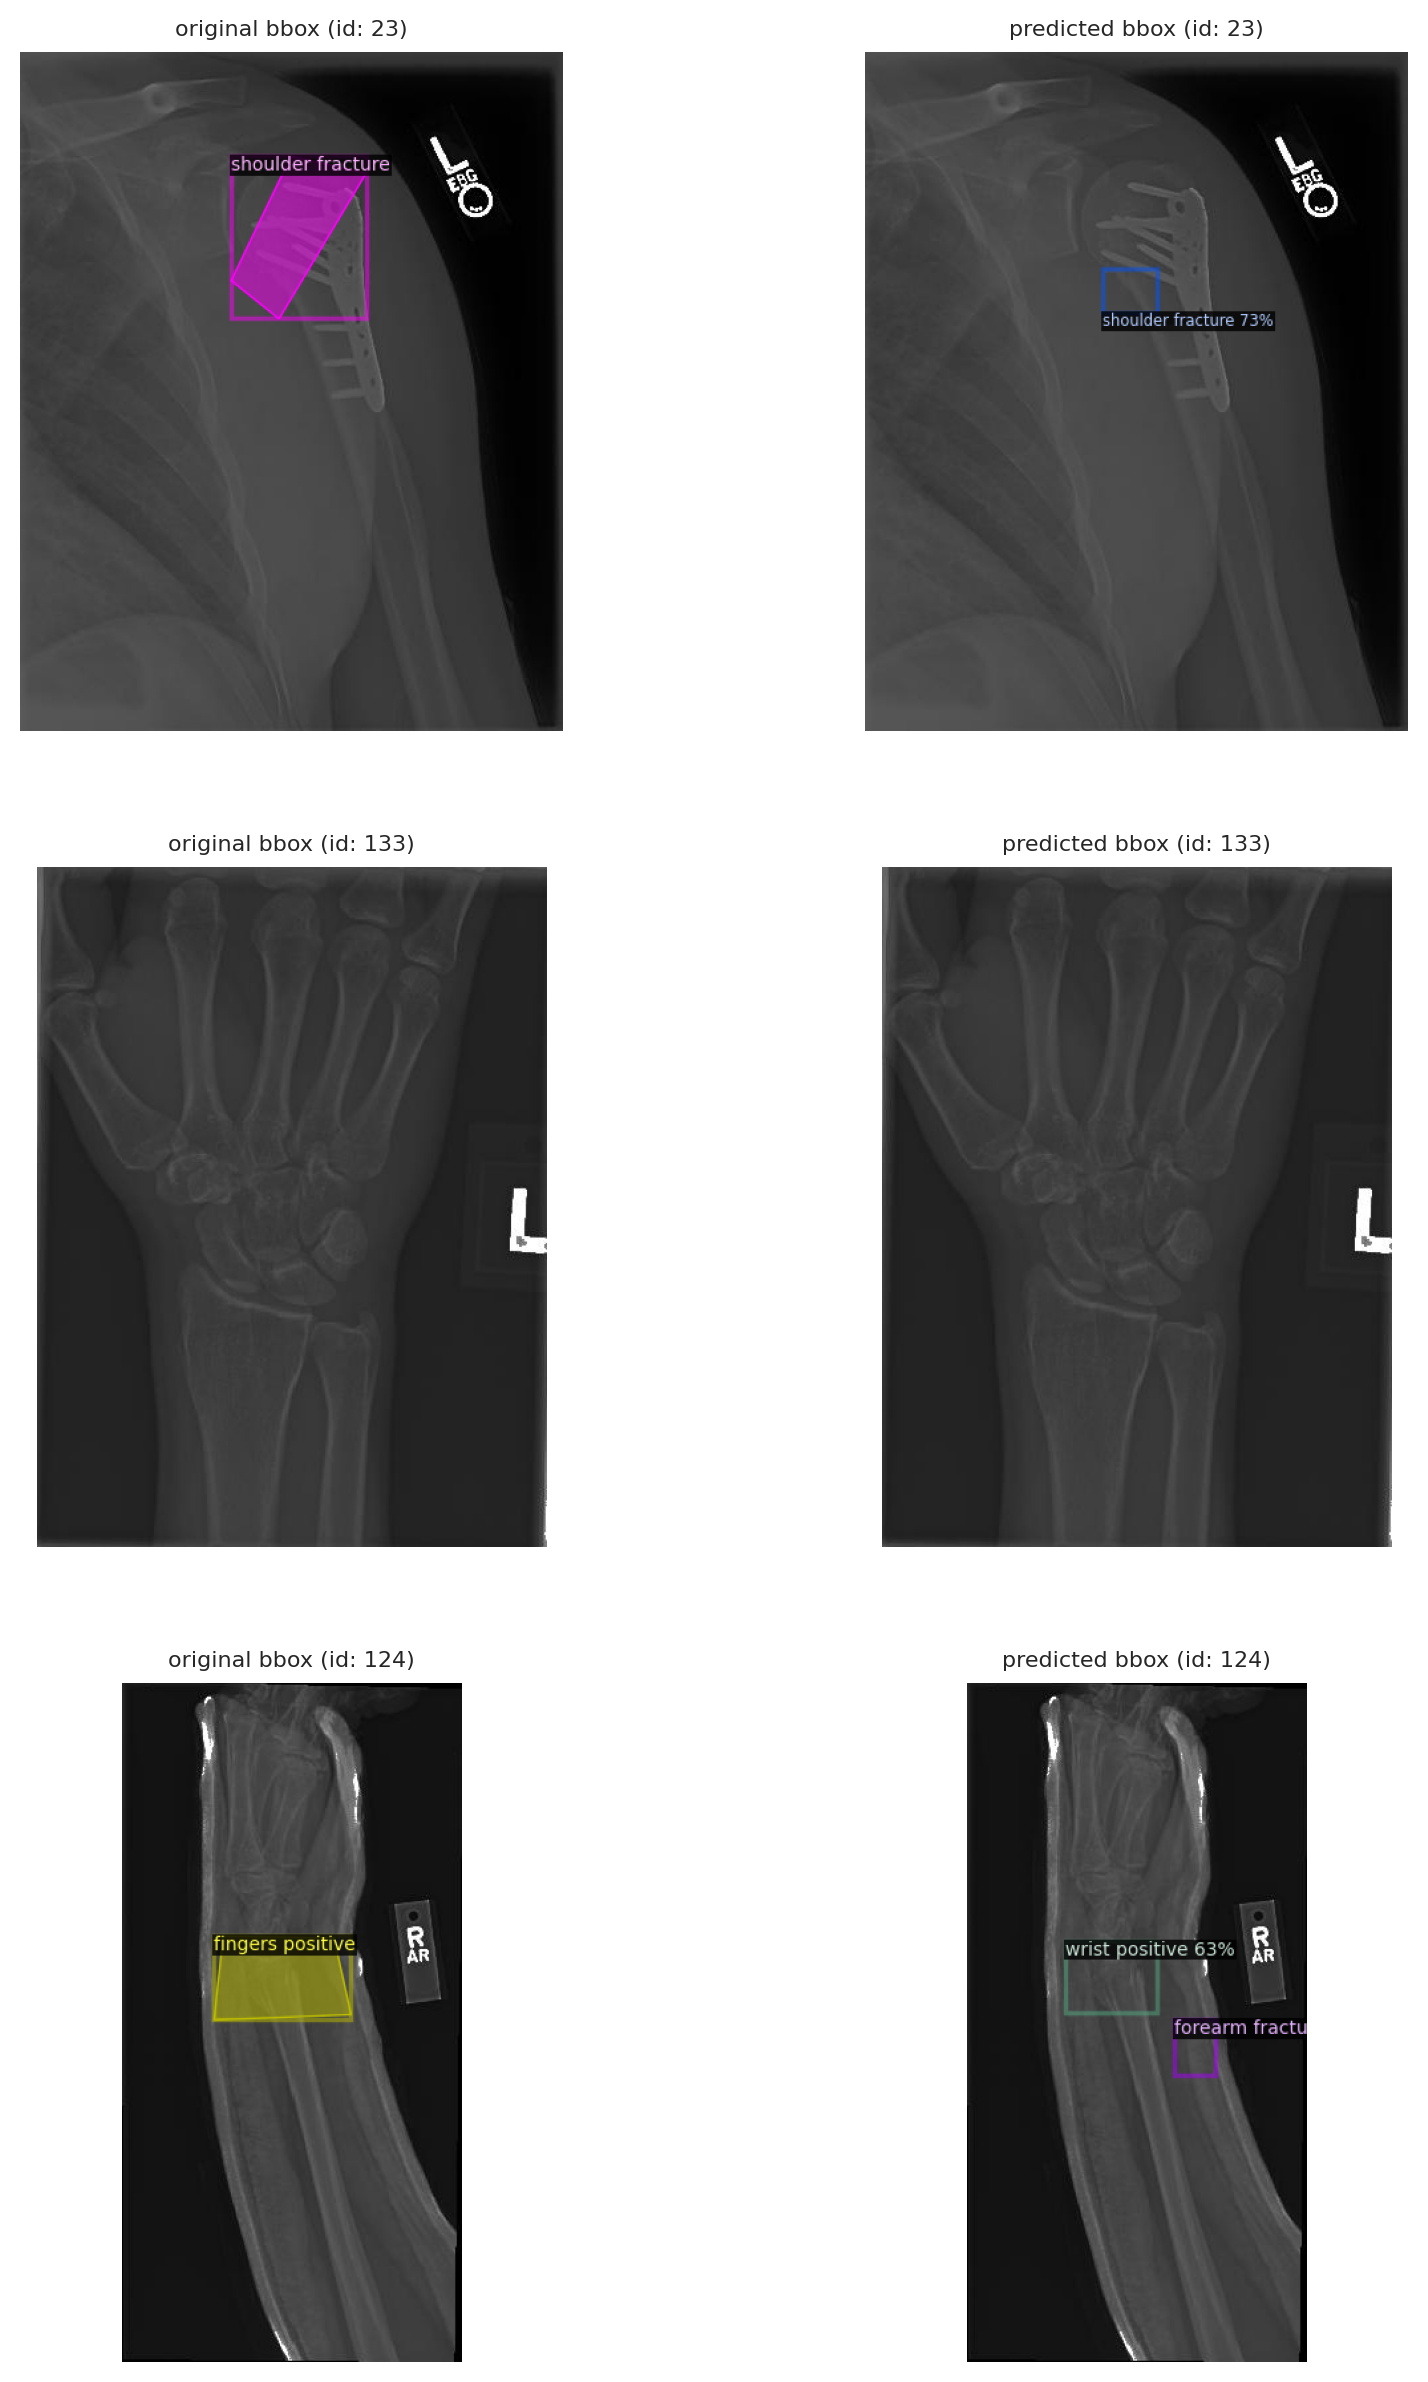

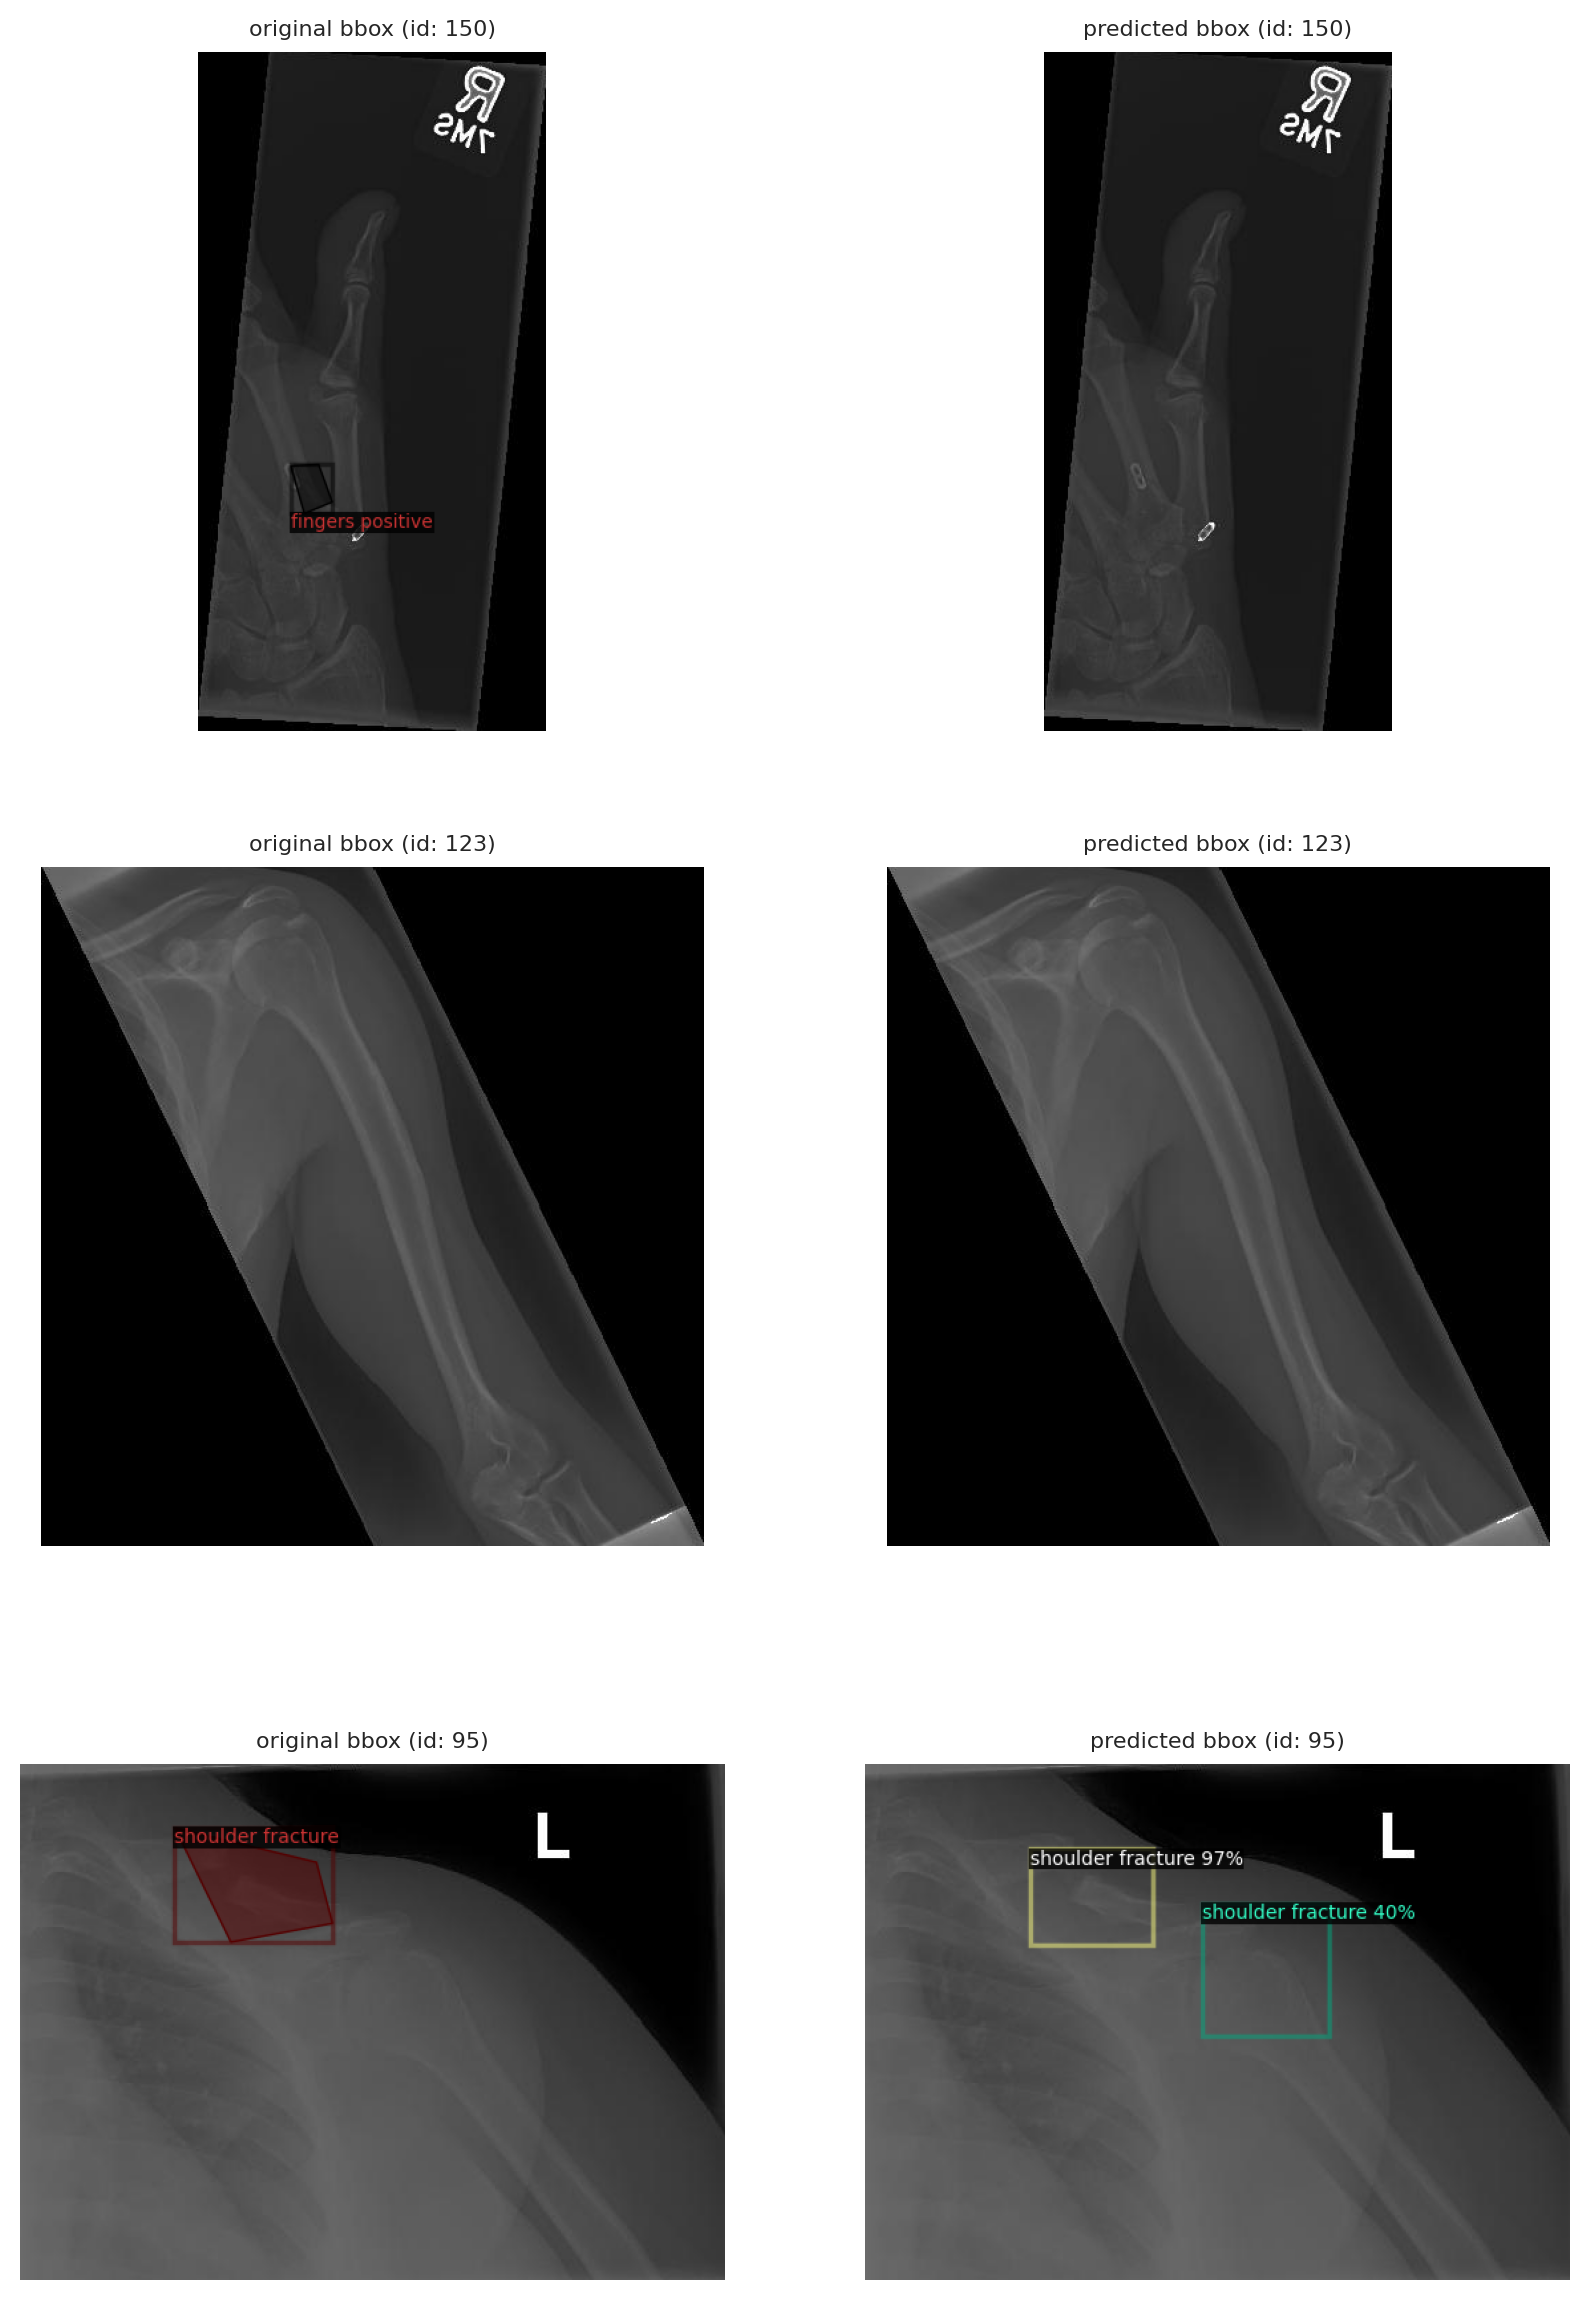

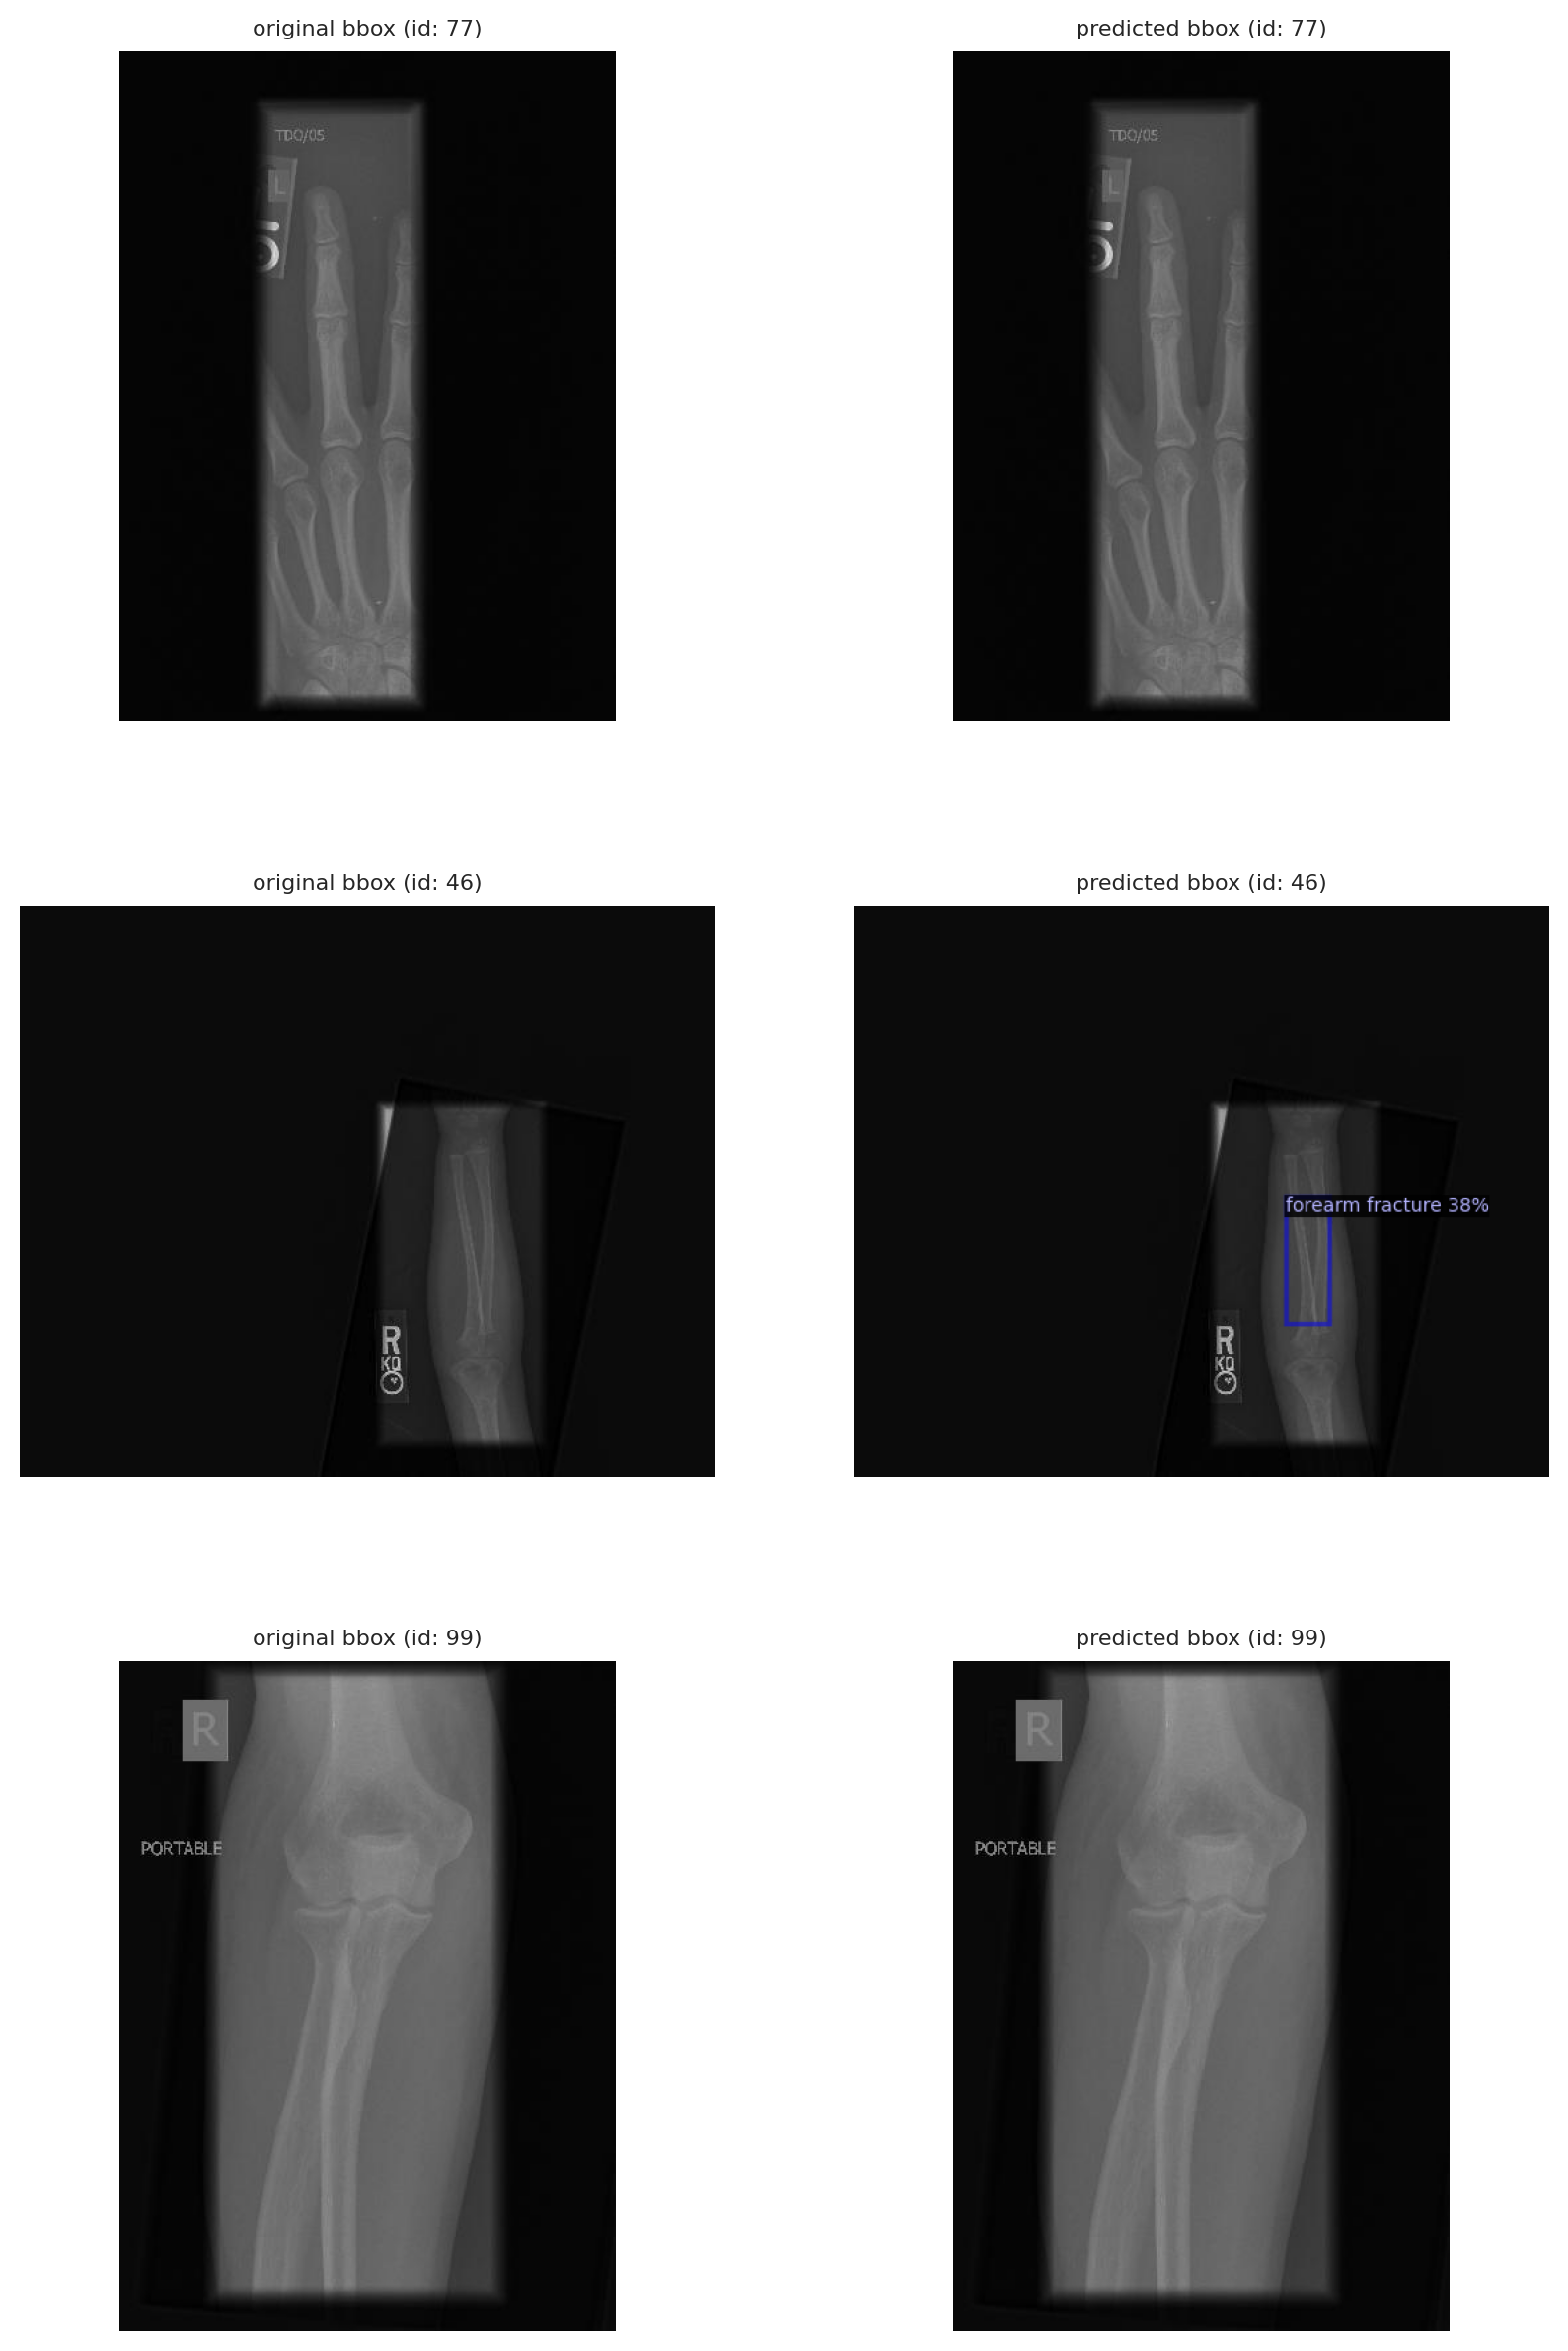

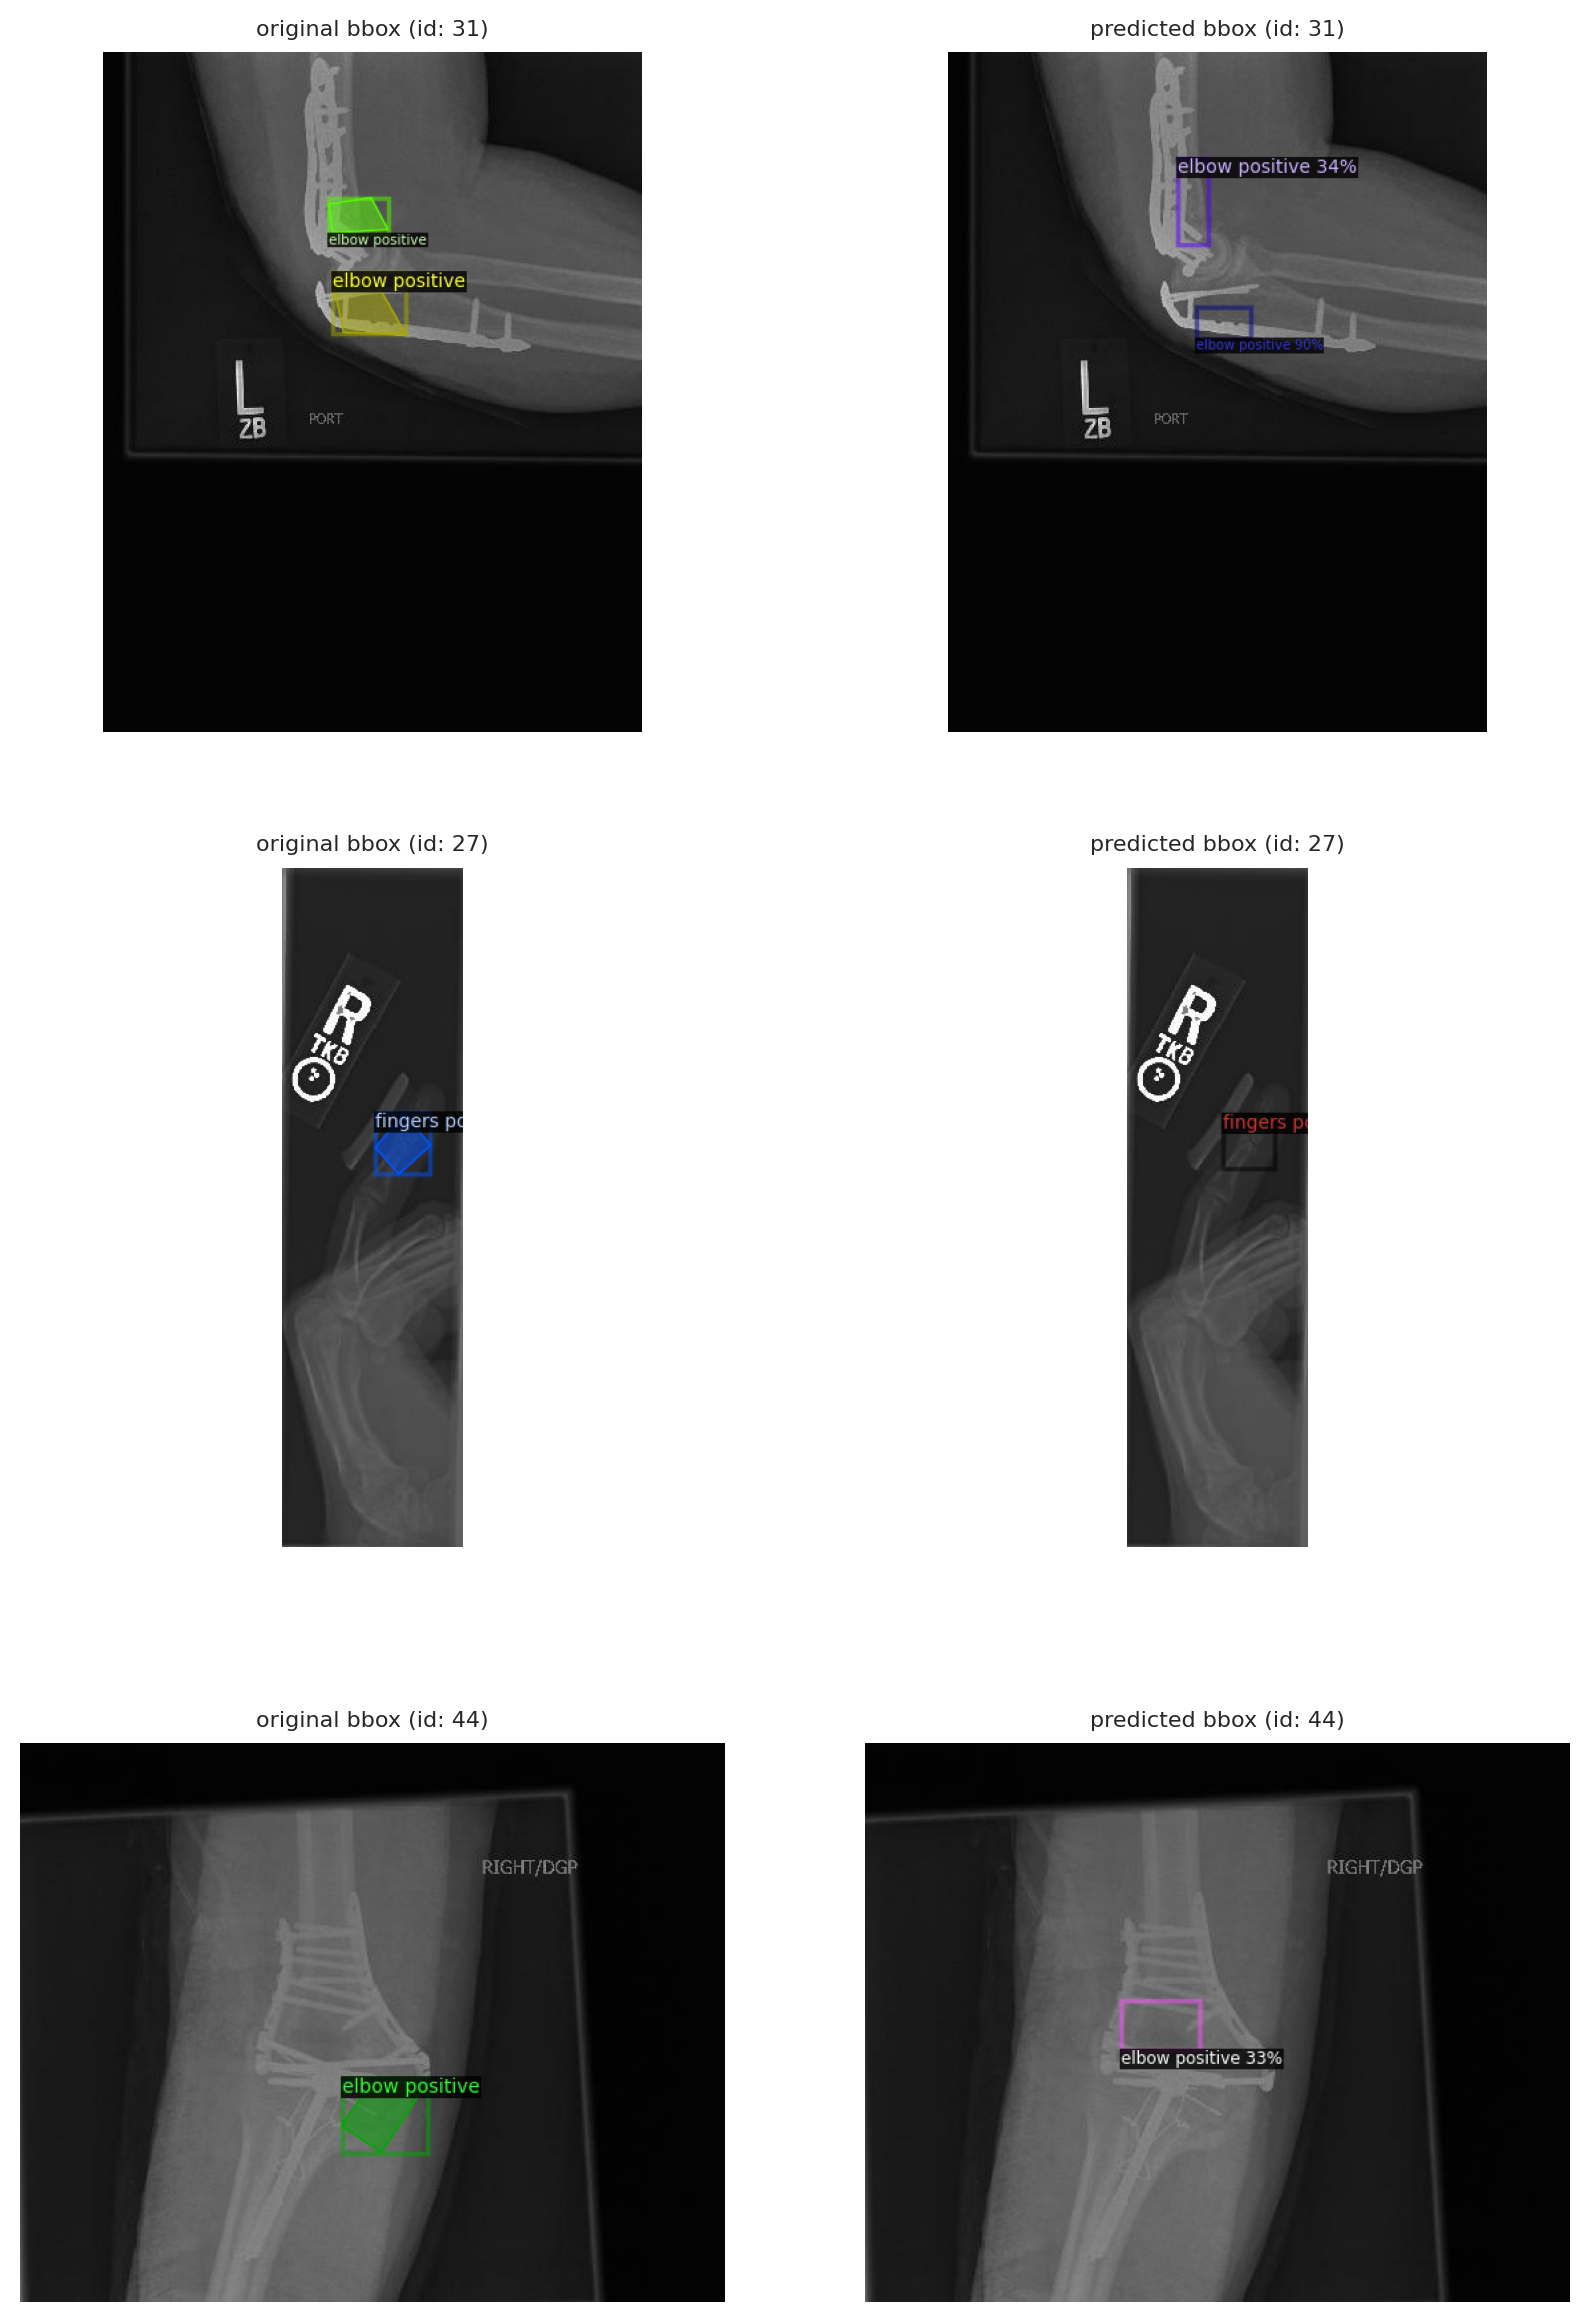

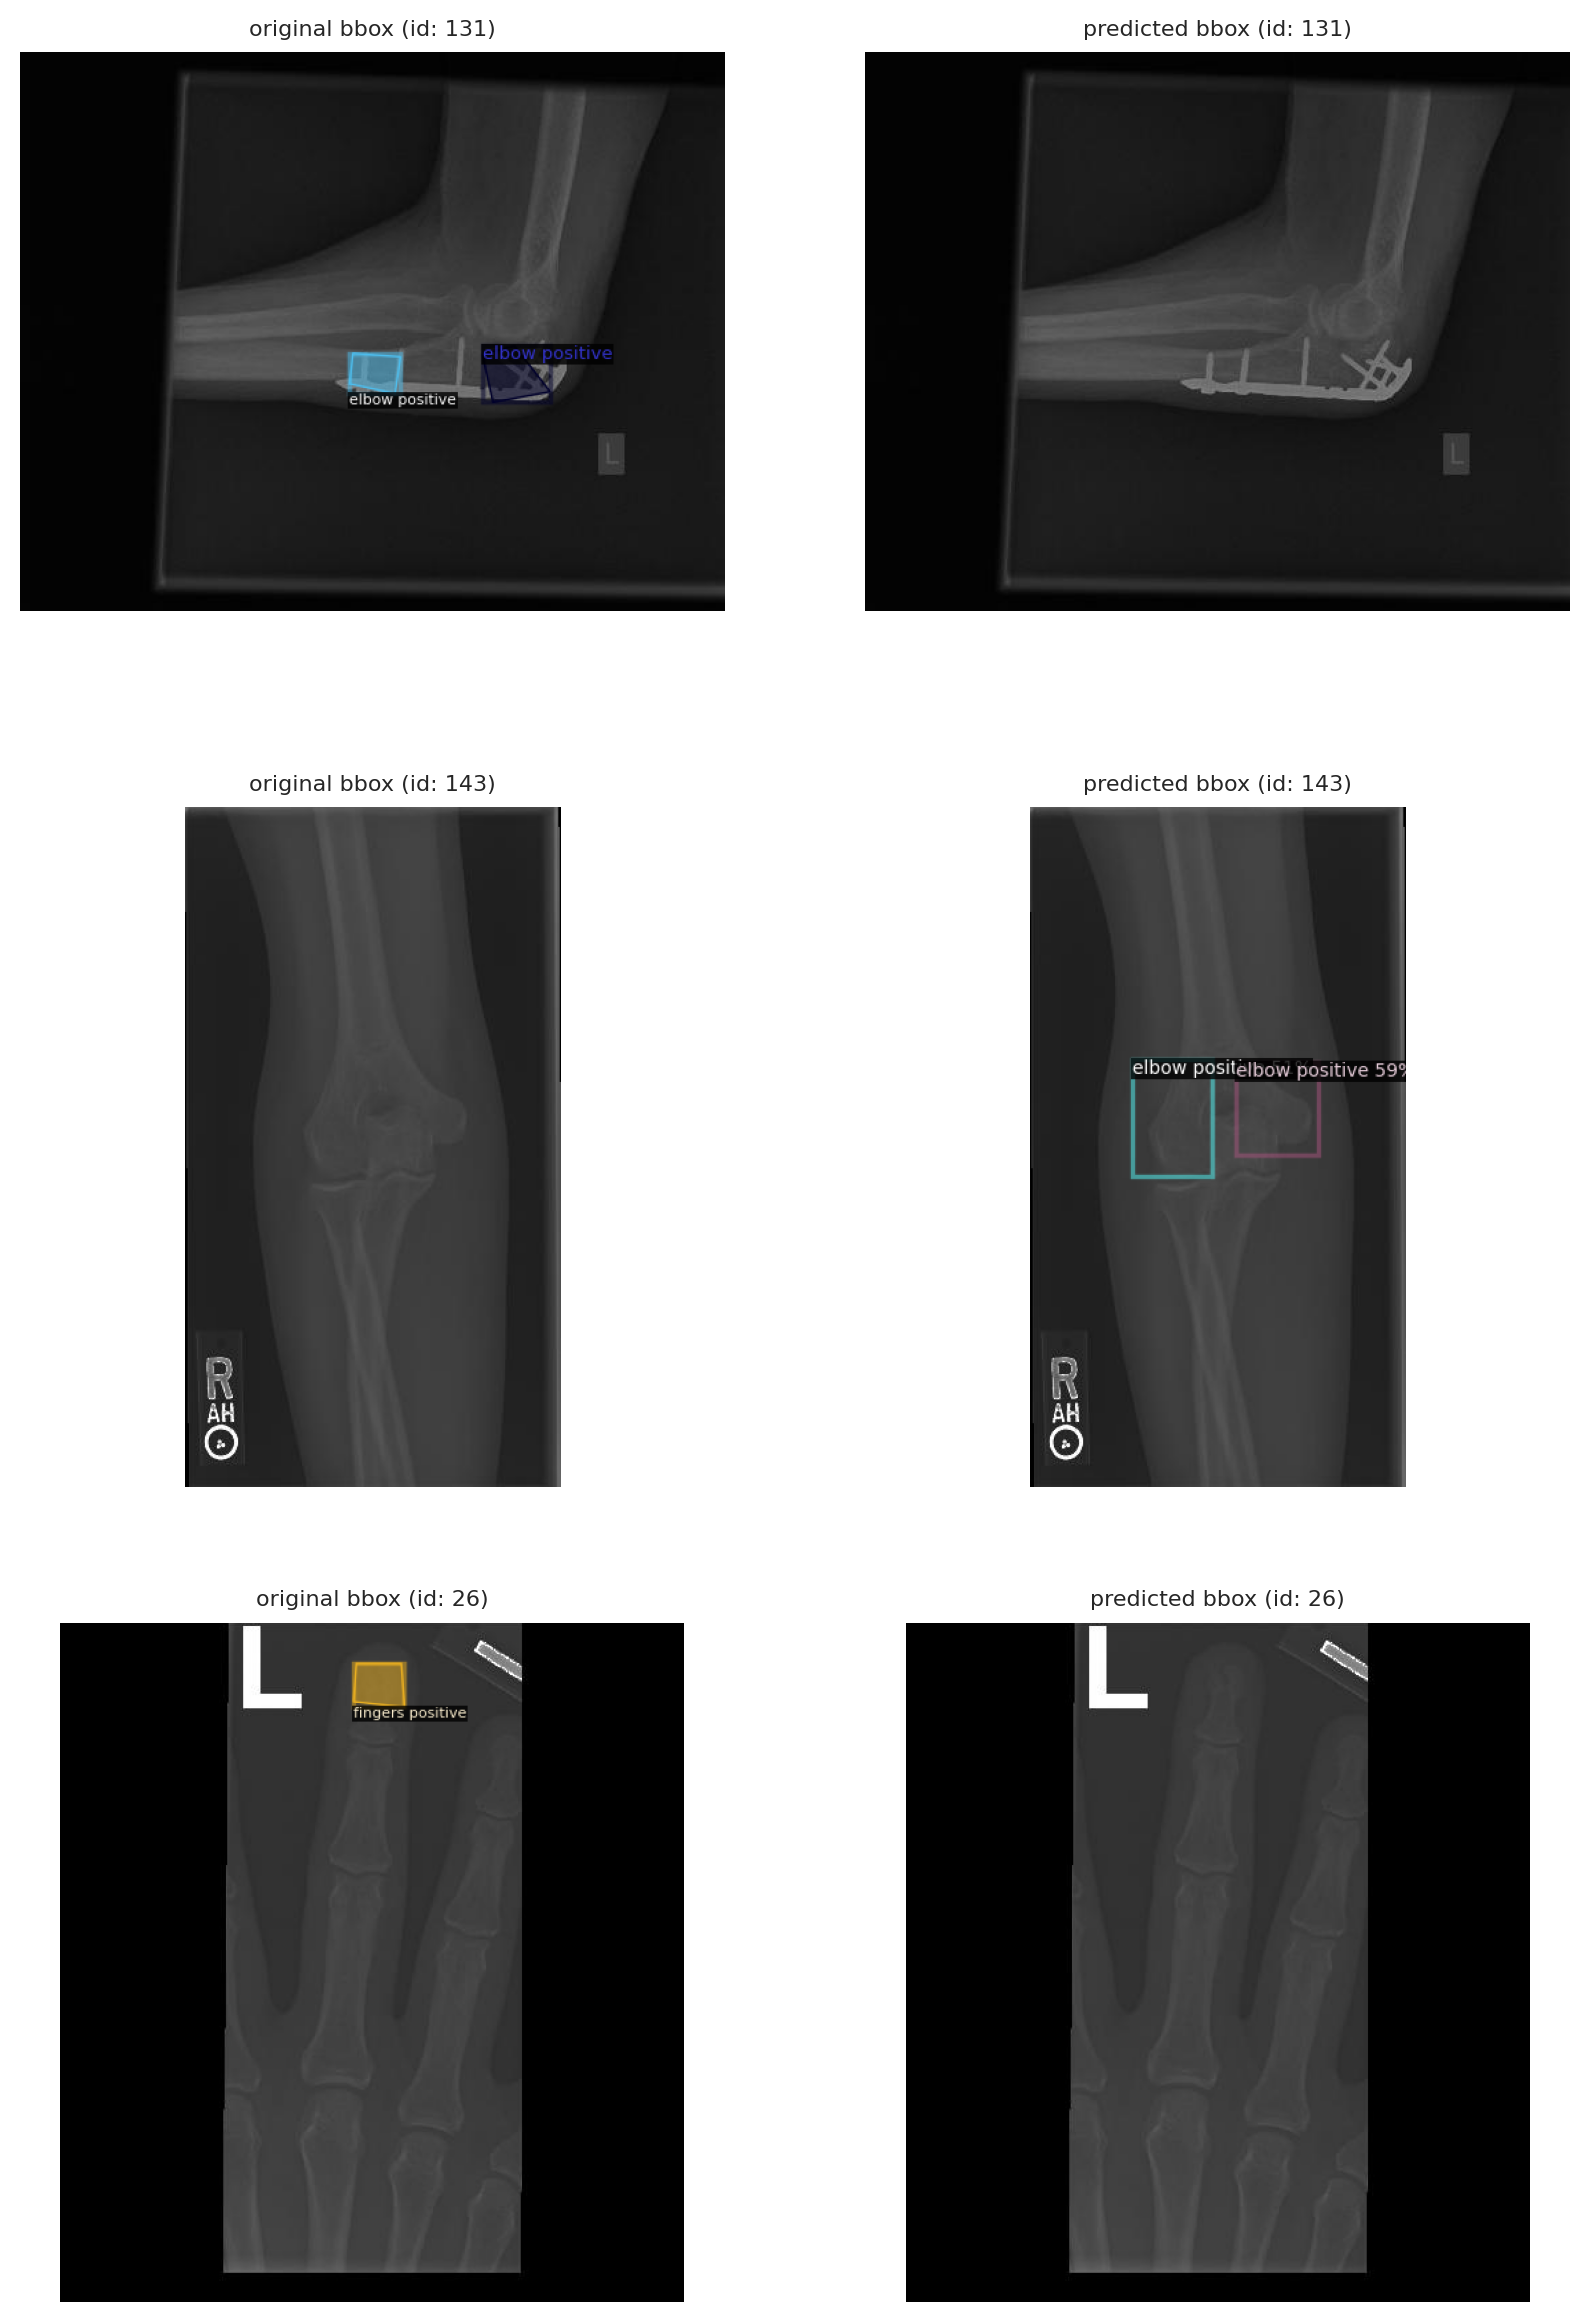

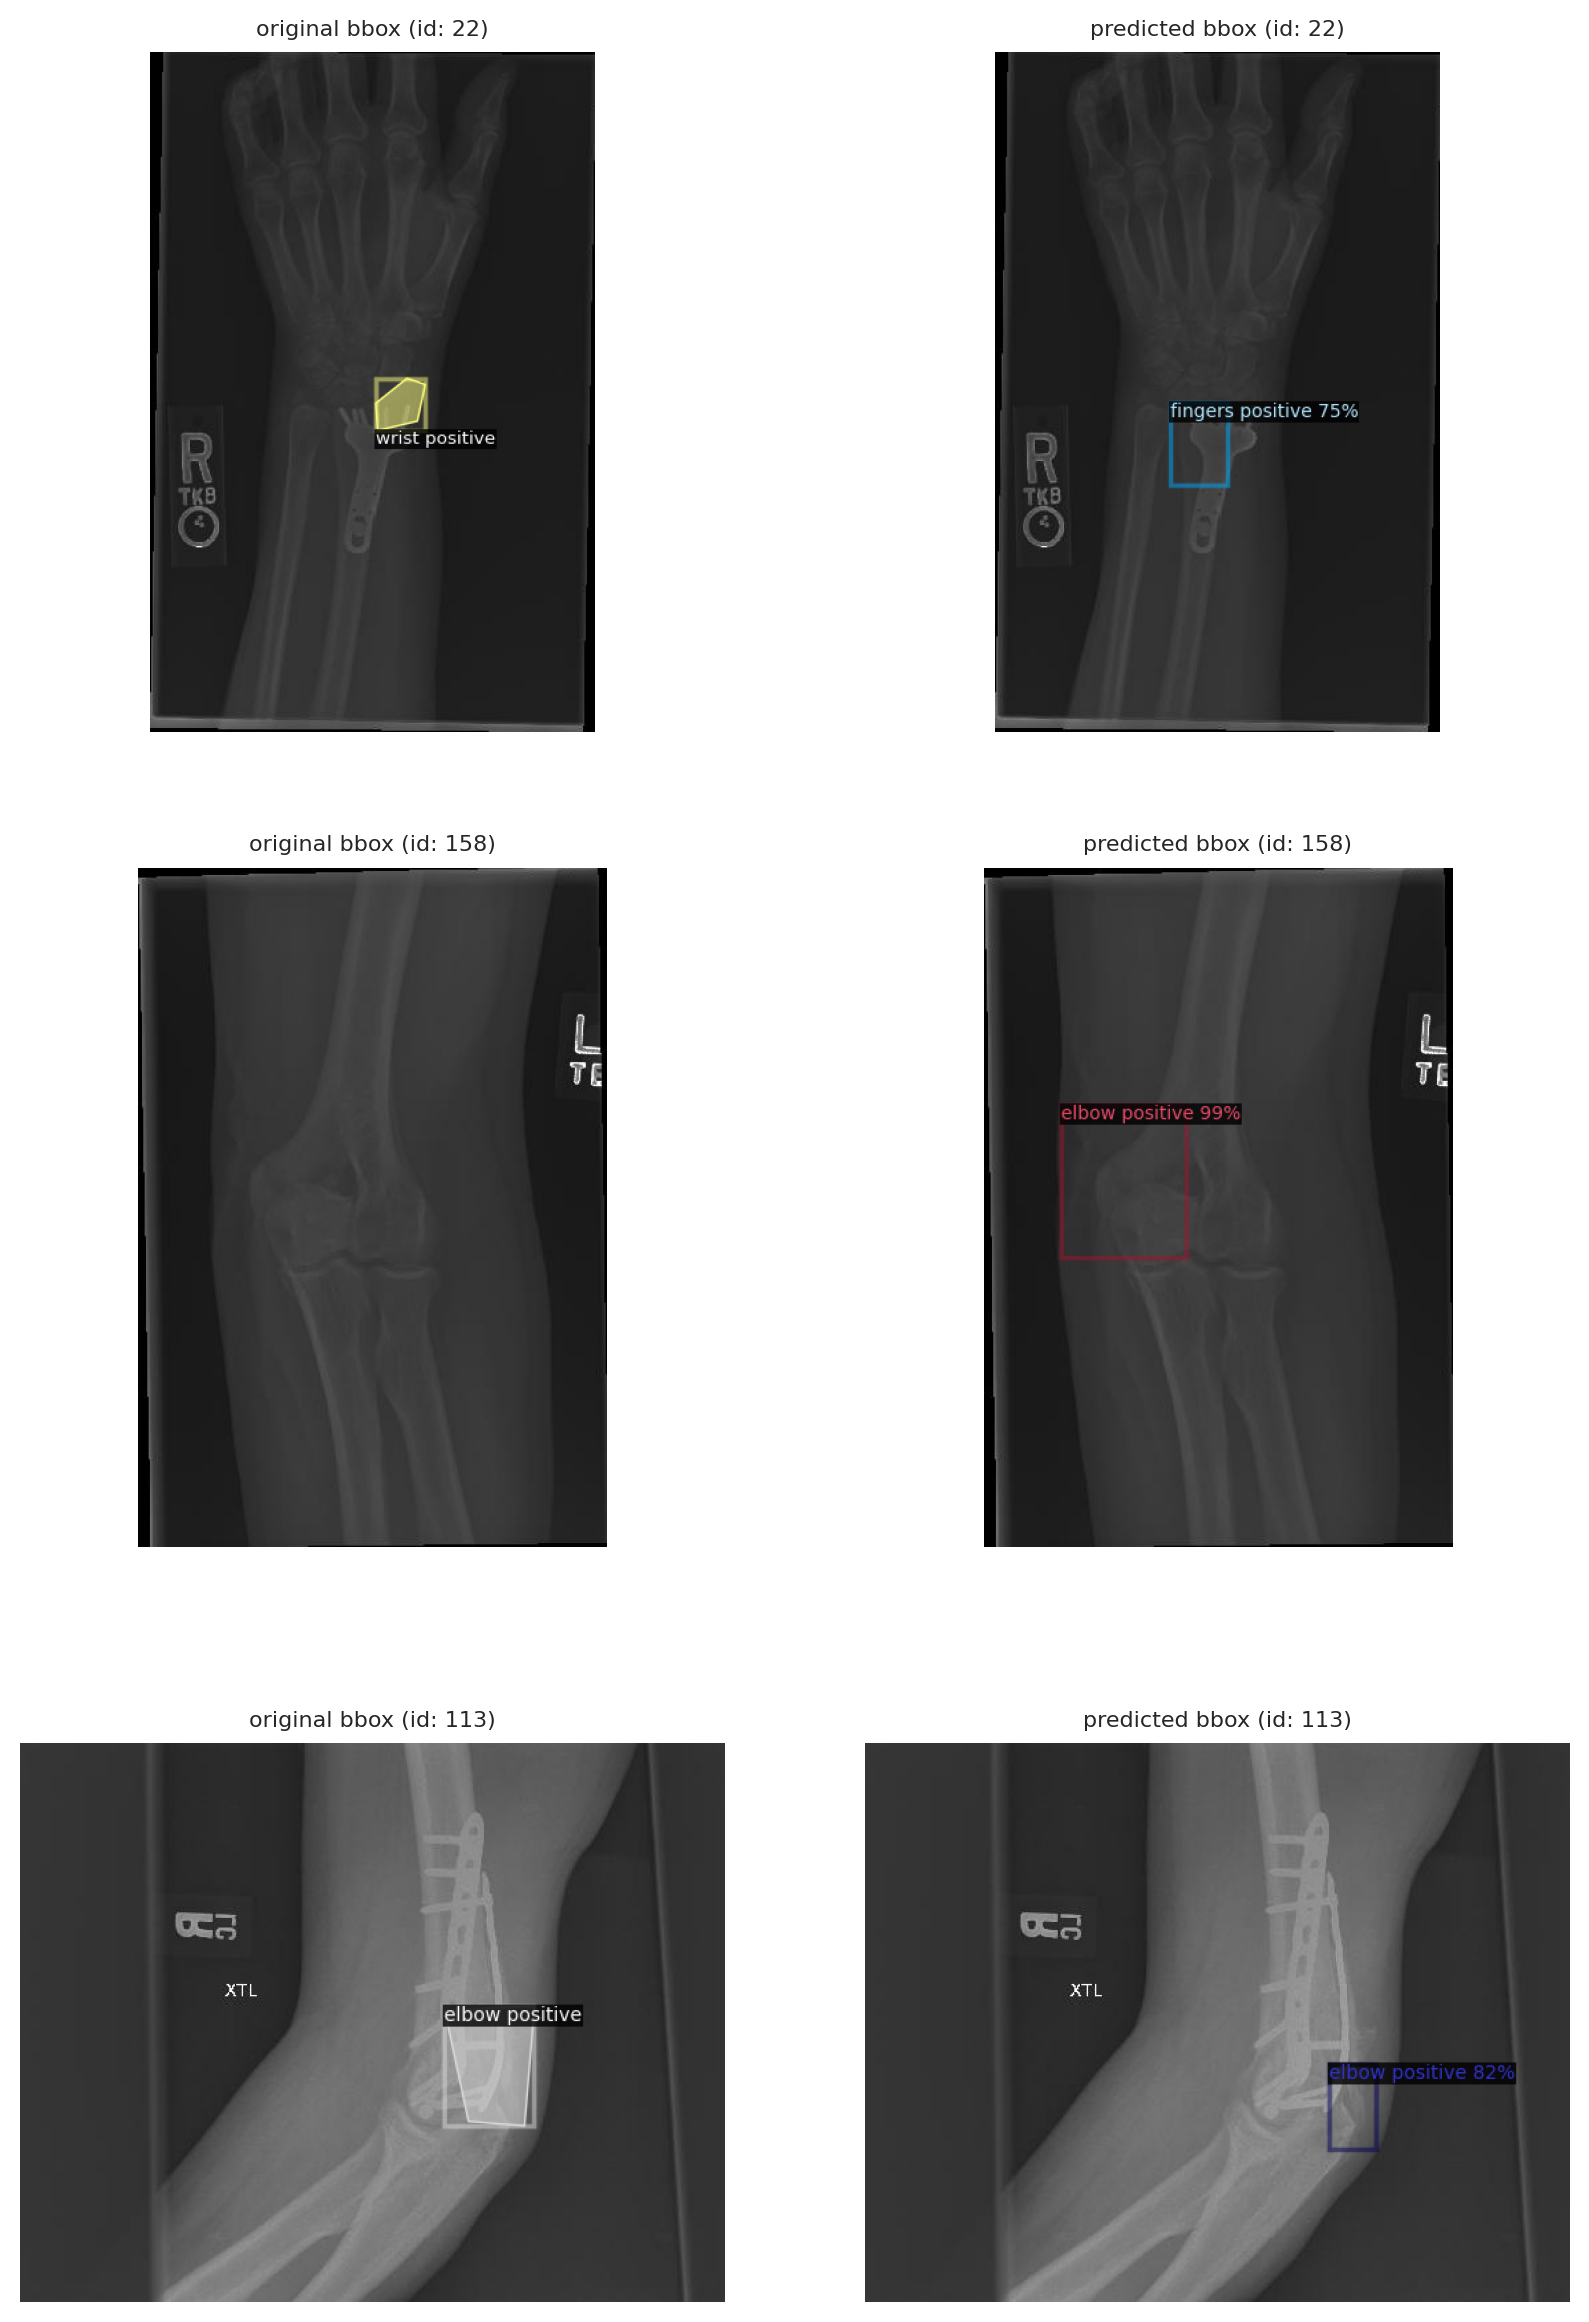

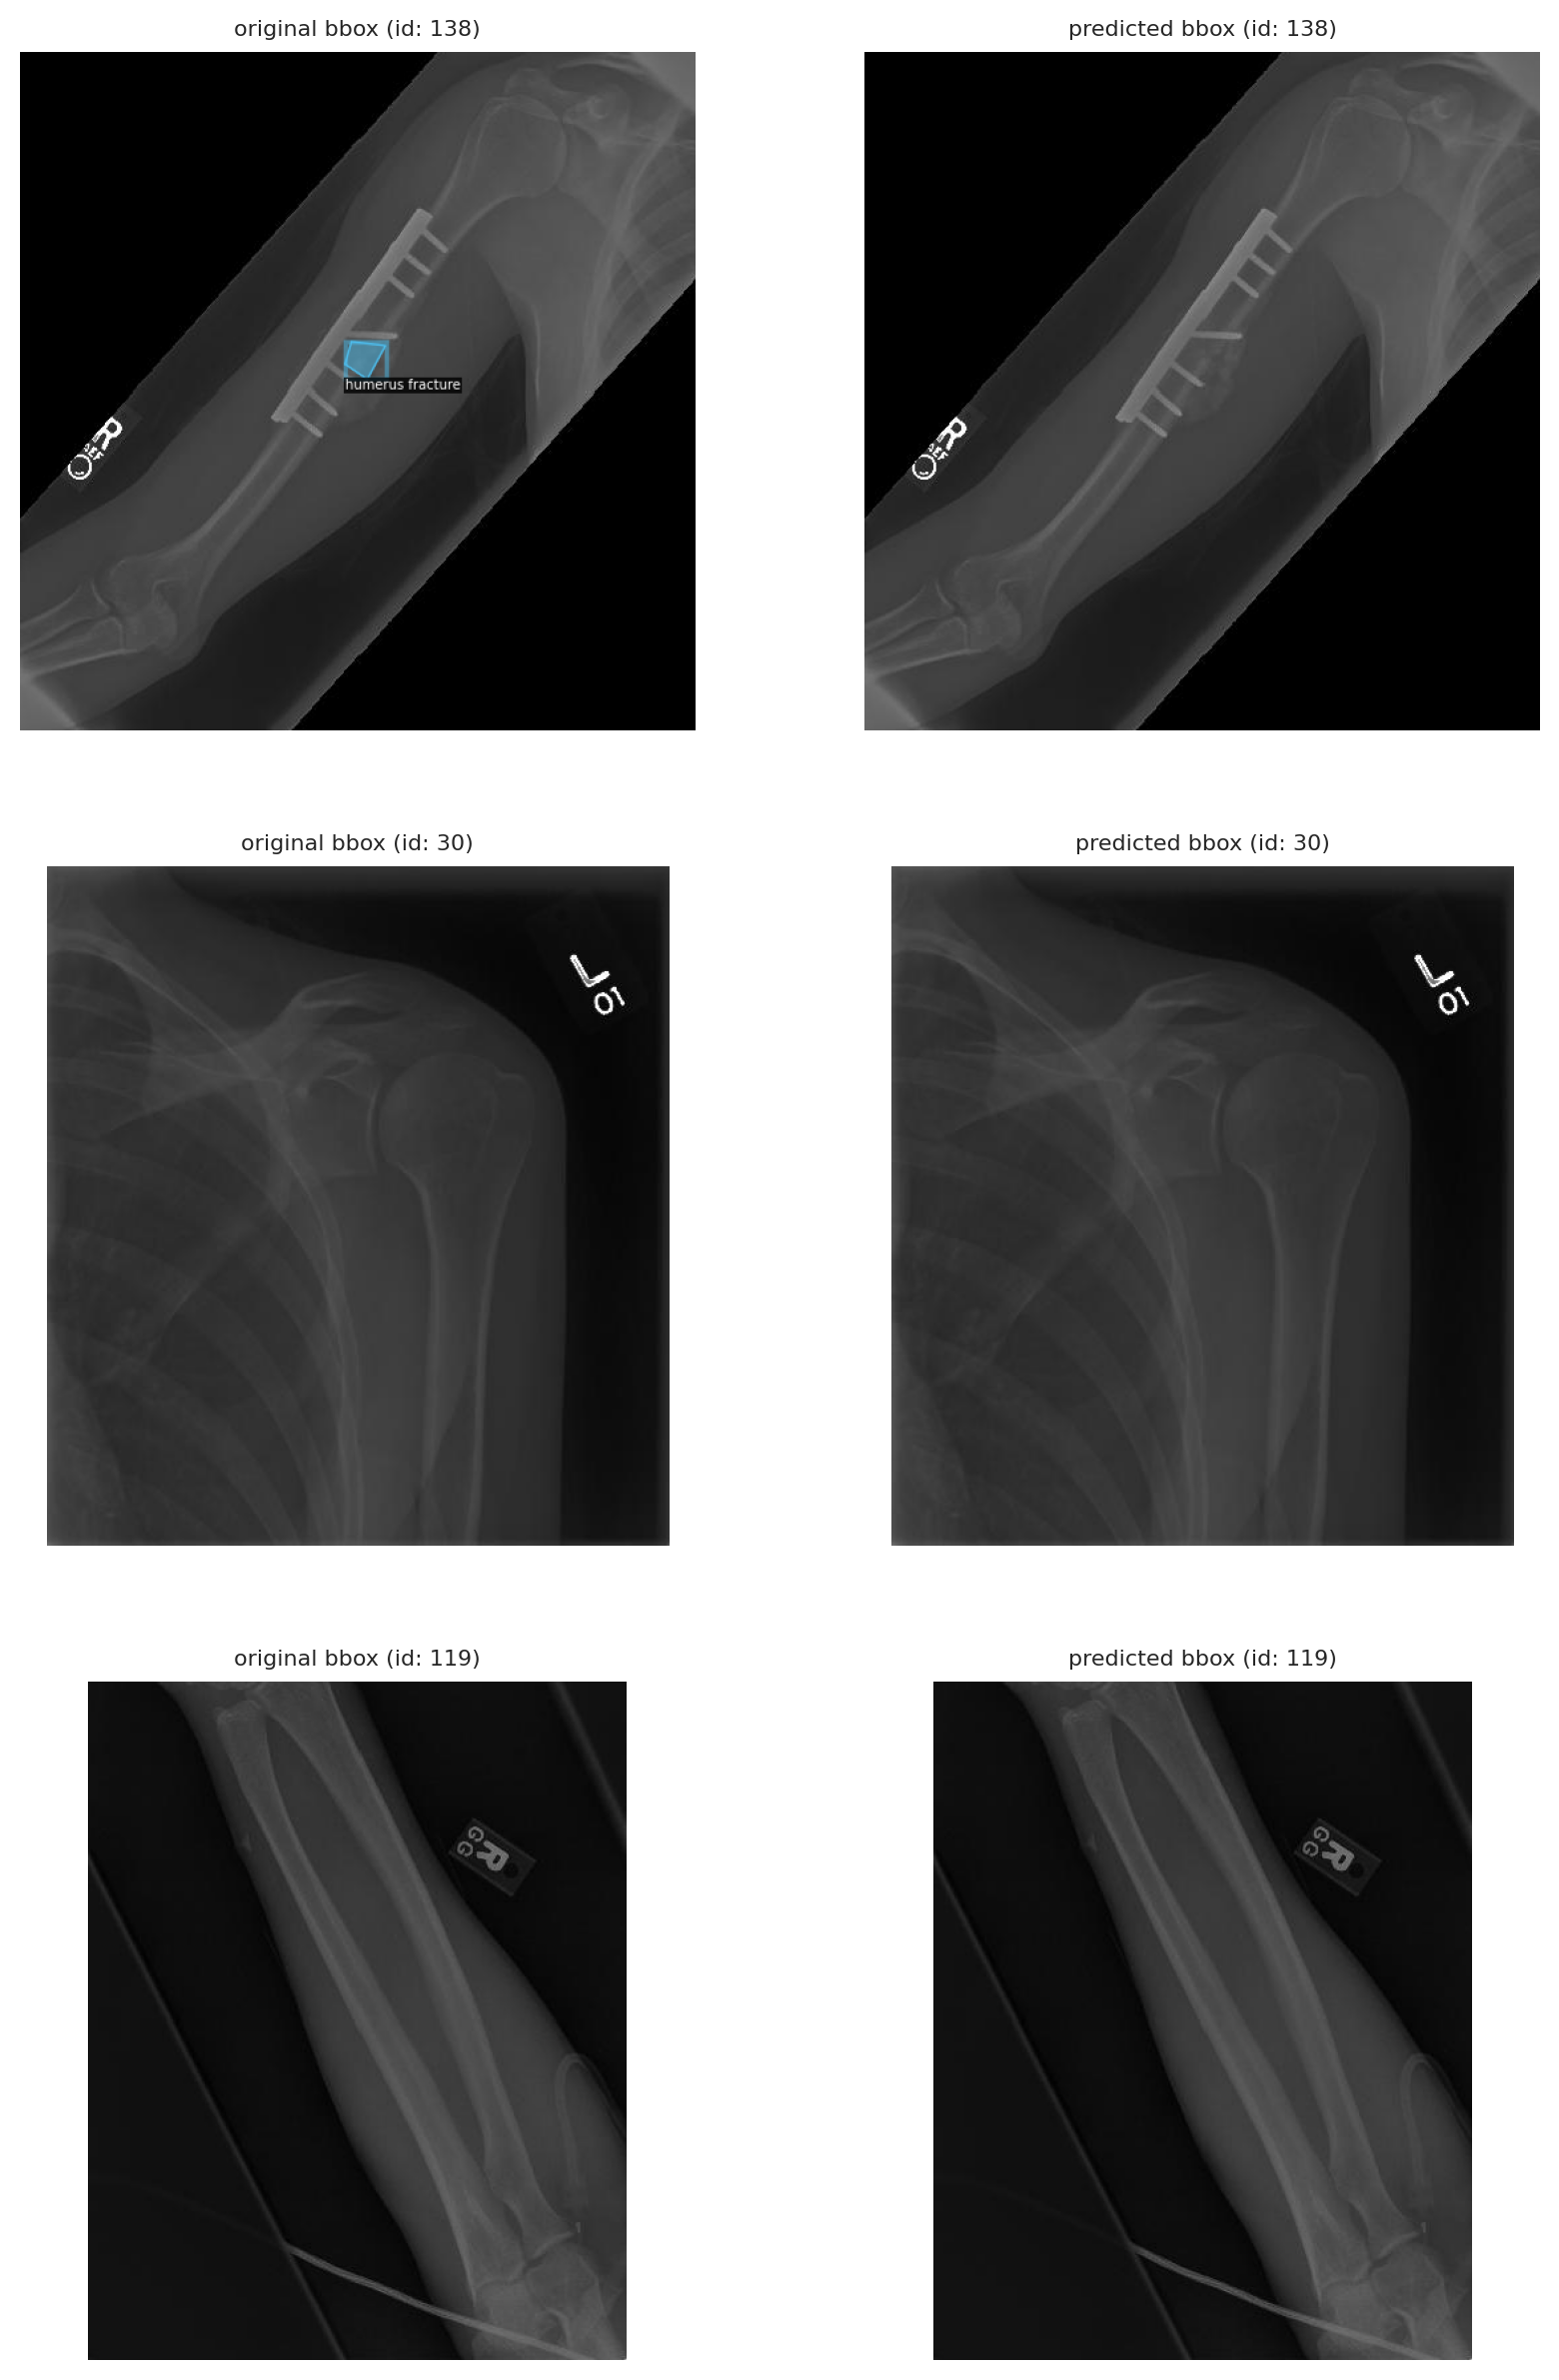

In [ ]:
for i in range(10):
  create_predictions(test_dataset_dicts,test_metadata,seed = random.randint(0,999), image_scale=1)

For web images

(1024, 474, 3)


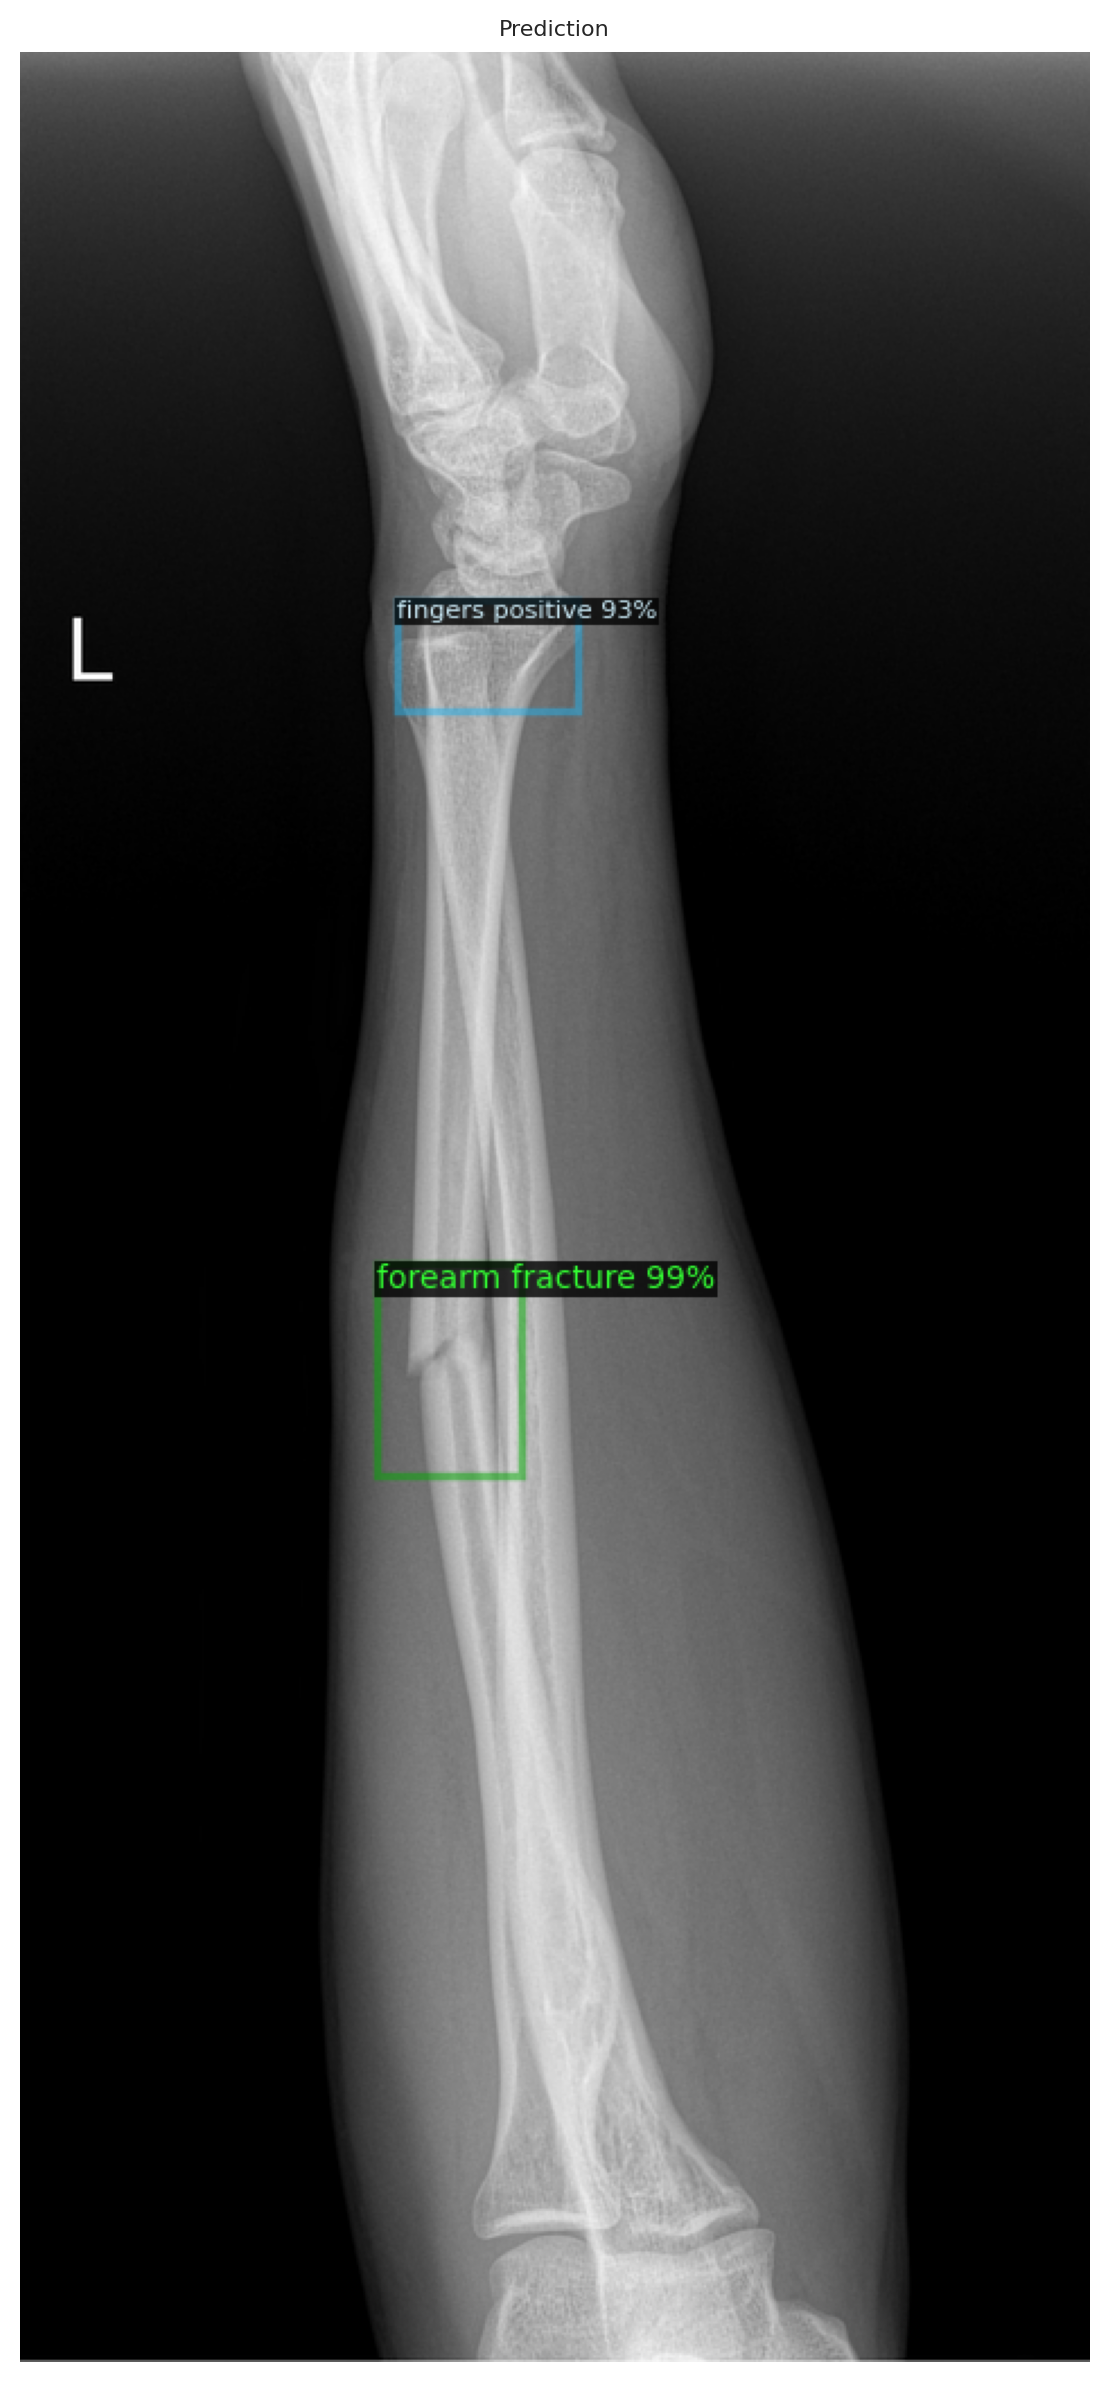

In [ ]:
import urllib.request

def predict_new(link, dataset_metadata, image_scale=1):
    req = urllib.request.urlopen(link)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    img = cv2.imdecode(arr, -1)

    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    if img.shape[2] == 4:  # Check if the image has 4 channels
        img = img[:, :, :3]


    print(img.shape)

    visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_metadata, scale=image_scale)
    outputs = predictor(img)
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    out_img = out.get_image()[:, :, ::-1]

    # Plot
    plt.figure(figsize=(10, 15), dpi=200)
    plt.title('Prediction', fontsize=8)
    plt.axis('off')
    plt.imshow(out_img)
    plt.show()

link = 'https://i.ibb.co/XF6p0LB/c81e5bee621637e3630142cbc38f42e1a45ba2c5c8460f1b354e6462e25cfb8a-jumbo.png'
predict_new(link, test_metadata)